In [1]:
# More details at https://confluence.slac.stanford.edu/display/LSSTDESC/SLAC+2016+-+DE+School

In [2]:
%matplotlib inline
#%connect_info
%load_ext Cython
%load_ext autoreload
%autoreload 2  # 0 disable, 1 for only %aimport objects, 2 for those EXCEPT %aimport

# numpy and matplotlib already imported
from __future__ import print_function, division
import numpy as np
import random,cPickle,itertools
import time,glob,probfit,sys
import matplotlib.pyplot as plt
import seaborn as sb
from itertools import cycle
from astropy.io import fits
from scipy.optimize import leastsq
from matplotlib.colors import LogNorm
from iminuit import Minuit, describe, Struct
sys.path.insert(1,'/home/andrew/Work/ccd/wavefronts/')
from donutengine import donutengine
from psf_evaluator import Moment_Evaluator
# import fitsio
# import pandas as pd
import matplotlib
matplotlib.rc('font',size=20)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

# instantiate Fraunhofer engine
inputDict = {"nZernikeTerms":11,"nbin":256,"pixelOversample":16,"iTelescope":3} #was 11,256,16
engine = donutengine(**inputDict)

In [58]:
stamp

array([[ -4.40102104e-05,  -1.54035736e-04,  -1.54035736e-04,
         -6.16142945e-04,  -1.10025526e-04,  -6.60153156e-05,
          1.54035736e-04,   7.92183787e-04,   9.24214418e-04,
          1.05624505e-03,   7.92183787e-04,   5.06117419e-04,
         -4.18096999e-04,   1.10025526e-04,   2.20051052e-05,
         -2.64061262e-04],
       [ -1.10025526e-04,  -3.52081683e-04,  -2.86066367e-04,
         -8.80204207e-05,   1.98045947e-04,   5.50127630e-04,
          1.27629610e-03,   2.44256668e-03,   3.25675557e-03,
          3.60883725e-03,   2.64061262e-03,   1.69439310e-03,
          7.04163366e-04,   3.74086788e-04,  -2.20051052e-05,
         -3.74086788e-04],
       [ -1.10025526e-04,  -1.54035736e-04,  -4.40102104e-05,
          0.00000000e+00,   8.14188892e-04,   2.33254115e-03,
          4.51104656e-03,   5.94137840e-03,   7.94384297e-03,
          7.21767450e-03,   6.13942435e-03,   4.57706188e-03,
          3.45480151e-03,   1.89243905e-03,   4.84112314e-04,
         -1.9804

In [59]:


def donut_extractor(ith,catalog_FOREVERSAVED,image_FOREVERSAVED):
    stampsize = 8
    half_x_size = stampsize
    half_y_size = stampsize
    
    x = catalog_FOREVERSAVED[ith]['XWIN_IMAGE']
    y = catalog_FOREVERSAVED[ith]['YWIN_IMAGE']
    y_min = int(y - half_y_size)
    y_max = int(y + half_y_size)
    x_min = int(x - half_x_size)
    x_max = int(x + half_x_size)
    stamp = image_FOREVERSAVED[y_min: y_max,
                  x_min: x_max]
    stamp-=np.median(stamp[stamp<.05*stamp.max()])
    return stamp / stamp.sum()+1e-6

def donut_extractor2(ith,catalog_FOREVERSAVED,image_FOREVERSAVED):
    stampsize = 8
    half_x_size = stampsize
    half_y_size = stampsize
    
    x = catalog_FOREVERSAVED[ith]['XWIN_IMAGE']
    y = catalog_FOREVERSAVED[ith]['YWIN_IMAGE']
    y_min = int(y - half_y_size)
    y_max = int(y + half_y_size)
    x_min = int(x - half_x_size)
    x_max = int(x + half_x_size)
    stamp = image_FOREVERSAVED[y_min: y_max,
                  x_min: x_max]
    bigstamp=image_
    stamp-=np.median(stamp[stamp<.05*stamp.max()])
    return stamp

# simple class to make stars
def makeStar(FWHM=0.6,z2=0,z3=0,z4=0.,z5=0.,z6=0.0,z7=0.,z8=0.,z9=0.,z10=0.,z11=0.):
    """ make a star
    z2/3=x/y tilt, z4=focus, z5/6=x/y astigmatism,z7/8=x/y coma, z9/10=x/y trefoil, z11=spherical
    """
    # flux & wavefront parameters
    flux = 1.
    fried_parameter = 0.14/FWHM
    skybackground = 0
    par = np.array([flux,fried_parameter,skybackground,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11])

    # make the star
    engine.calcAll(par)

    # add noise
    #readnoise = 7.0
    #nranval = np.random.normal(0.0,1.0,engine.calcImage.shape)
    #stamp = engine.calcImage + nranval*np.sqrt(engine.calcImage + readnoise)
    stamp = engine.calcImage

    # cheat and subtract background
    stamp = stamp - skybackground
    
    # done
    return stamp

def fit_func(p, stamp):
    return (stamp - makeStar(*p)).flatten()

#out = leastsq(fit_func, x0, args=(stamp),maxfev=600, full_output=True)

In [78]:
framename.split('_')[-2]

'114'

In [4]:
thedir='/home/andrew/Work/ccd/20170330-focus_curve/'

In [5]:
# load the donut catalog and image

allframelist=np.sort(glob.glob(thedir+'*whole.fits'))
#print(allframelist)

framename=allframelist[-1]
image = fits.getdata(framename)
image -= np.median(image)
catalog = fits.getdata(framename+'.cat',"LDAC_OBJECTS")
stampsize=20

good=np.where((catalog['XWIN_IMAGE']>stampsize*2) & (catalog['YWIN_IMAGE']>stampsize*2) &
          (catalog['XWIN_IMAGE']<3900) & (catalog['YWIN_IMAGE']<3900) & (catalog['FLAGS']==0))
catalog=catalog[good]




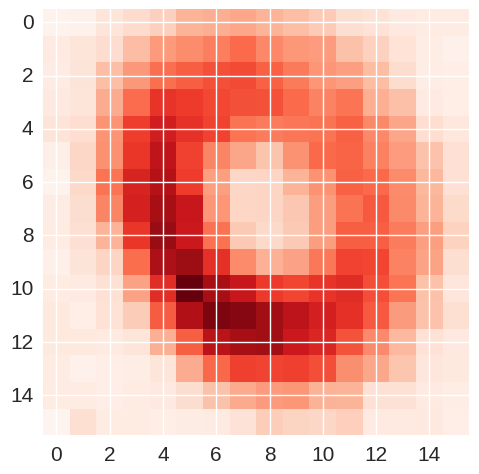

In [6]:
ith = np.random.randint(0,len(catalog),1)#20030#563720009 #

stamp = donut_extractor(ith,catalog,image)
plt.imshow(stamp,
           interpolation='None',
           cmap=plt.cm.Reds)

In [7]:
tstart=time.time()

#stamp = donut_extractor(ith,catalog,image)
x0 = [0.2] + [0,0,3,-.3,.3,0,0,0,0,0]#list(m.args)#
#fwhm + [xtil,ytil,foc,xast,yast, xcom,ycom, xtre,ytre, sph]
#z2/3=x/y tilt, z4=focus, z5/6=x/y astigmatism,z7/8=x/y coma, z9/10=x/y trefoil, z11=spherical

out = leastsq(fit_func, x0, args=(stamp), full_output=True)#,maxfev=60000
print(out[0])
print(time.time()-tstart)

/home/andrew/Work/ccd/wavefronts/donutengine.py:820: RuntimeWarning: invalid value encountered in power
  shftarrAtmos = numpy.exp(-3.44*pow(self.shftrAtmos*self.wavelength*self.fLength/self.rzero,5./3.))


[  4.00667380e+01   2.15805200e+00   1.03935055e+00   4.22429047e+00
   5.47985732e-01  -4.91864022e-01   3.21890592e-01  -3.42085776e-01
   1.46736066e-02  -6.10594420e-02   3.12326941e-01]
2.54925704002


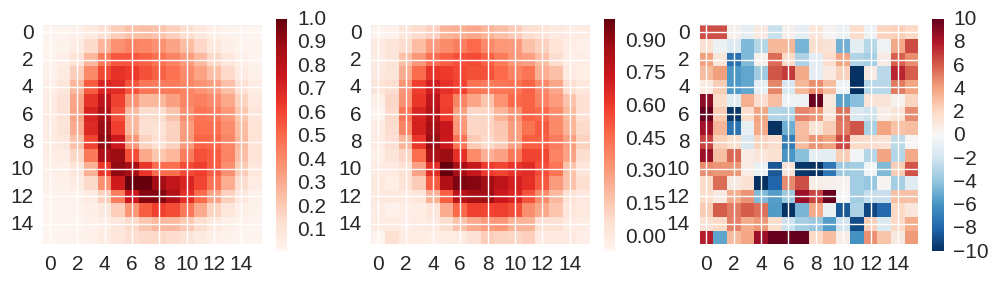

In [8]:
plt.figure(figsize=(12,3))
modelstamp=makeStar(*out[0])
plt.subplot(131)
plt.imshow(modelstamp/modelstamp.max(),interpolation='None',cmap=plt.cm.Reds)
plt.colorbar()
plt.subplot(132)
plt.imshow(stamp/stamp.max(), interpolation='None', cmap=plt.cm.Reds)
plt.colorbar()
plt.subplot(133)

plt.imshow((modelstamp/modelstamp.max() - stamp/stamp.max())*100.,
           interpolation='None',cmap=plt.cm.RdBu_r,vmin=-10,vmax=10)
plt.colorbar()

# Using iminuit

In [9]:
def iminuit_fit_func(fwhm,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11):
    modelstamp=makeStar(*[fwhm,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11])
    diff= (stamp/stamp.max() - modelstamp/modelstamp.max()).flatten()
    chi2=np.sum(diff**2)
    return chi2

#fwhm + [xtil,ytil,foc,xast,yast, xcom,ycom, xtre,ytre, sph]
#z2/3=x/y tilt, z4=focus, z5/6=x/y astigmatism,z7/8=x/y coma, z9/10=x/y trefoil, z11=spherical
fwhm,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11=[10]+[0]*10#list(m.args)

param_0=[20,1,1,0,
         .1,0,.1,0,
         .04,-.03,.14]
paramlim=np.array([(10,50),(-10,10),(-10,10),(.1,7),
          (-1,1),(-1,1),(-1,1),(-1,1),
          (-.1,.1),(-.1,.1),(-.5,.5)])
paramerr=np.array([2,3,3,1,
          .5,.5,.5,.5,
          .1,.1,.1])

m=Minuit(iminuit_fit_func,print_level=0,
         fwhm=fwhm,error_fwhm=paramerr[0],limit_fwhm=paramlim[0],
         z2=z2,error_z2=paramerr[1],limit_z2=paramlim[1],
         z3=z3,error_z3=paramerr[2],limit_z3=paramlim[2],
         z4=z4,error_z4=paramerr[3],limit_z4=paramlim[3],
         z5=z5,error_z5=paramerr[4],limit_z5=paramlim[4],
         z6=z6,error_z6=paramerr[5],limit_z6=paramlim[5],
         z7=z7,error_z7=paramerr[6],limit_z7=paramlim[6],
         z8=z8,error_z8=paramerr[7],limit_z8=paramlim[7],
         z9=z9,error_z9=paramerr[8],limit_z9=paramlim[8],
         z10=z10,error_z10=paramerr[9],limit_z10=paramlim[9],
         z11=z11,error_z11=paramerr[10],limit_z11=paramlim[10])


m.print_param()
#chi2 = probfit.Chi2Regression(makeStar_iminuit, np.array(x0), stamp.flatten(), np.sqrt(stamp).flatten())
#out = leastsq(fit_func, x0, args=(stamp),maxfev=600, full_output=True)

/home/andrew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:32: InitialParamWarning: errordef is not given. Default to 1.


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,fwhm,10,2,0,0,10.0,50.0,
2,z2,0,3,0,0,-10.0,10.0,
3,z3,0,3,0,0,-10.0,10.0,
4,z4,0,1,0,0,0.1,7.0,
5,z5,0,0.5,0,0,-1.0,1.0,
6,z6,0,0.5,0,0,-1.0,1.0,
7,z7,0,0.5,0,0,-1.0,1.0,
8,z8,0,0.5,0,0,-1.0,1.0,
9,z9,0,0.1,0,0,-0.1,0.1,
10,z10,0,0.1,0,0,-0.1,0.1,


5896 0.00279467000537


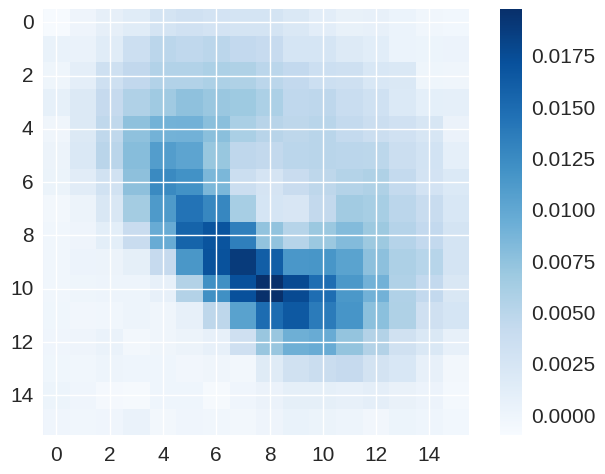

In [10]:
theind=np.random.randint(0,len(catalog))
stamp = donut_extractor(theind,catalog,image)
plt.imshow(stamp,interpolation='None',cmap="Blues")
print(theind,np.median(stamp))
plt.colorbar()

In [11]:
ME = Moment_Evaluator()
outD = ME(stamp)

e1= (outD['x2'] - outD['y2'])/(outD['x2']+outD['y2'])
e2= (2.*outD['xy'])/(outD['x2']+outD['y2'])
print(outD,e1,e2)

{'xy2': -2.3725861033741809, 'xy': 3.5016085616650114, 'x2': 6.8365929707339488, 'x3': 2.9611756622229057, 'y3': -8.5751412762864145, 'y2': 6.337574051371627, 'fwhm': 2.3608688642782205, 'flux': 0.50087506526247005, 'x2y': -2.5180018497648646, 'y': 8.1024457402323318, 'x': 7.5008503335396863, 'whisker': 1.8736293091549401} 0.0378785936542 0.531587090977


In [12]:
tstart=time.time()
m.migrad()
print(m.args)

print(time.time()-tstart)

(41.680913486362684, 1.1250328394756952, 0.805975896398019, 3.441412561306007, 0.9999889815971068, -0.08035997728591915, 0.6793727041100819, -0.4318326614735045, 0.014382233193646315, -0.017015626275927176, 0.459800828416578)
11.0623810291


<function matplotlib.pyplot.tight_layout>

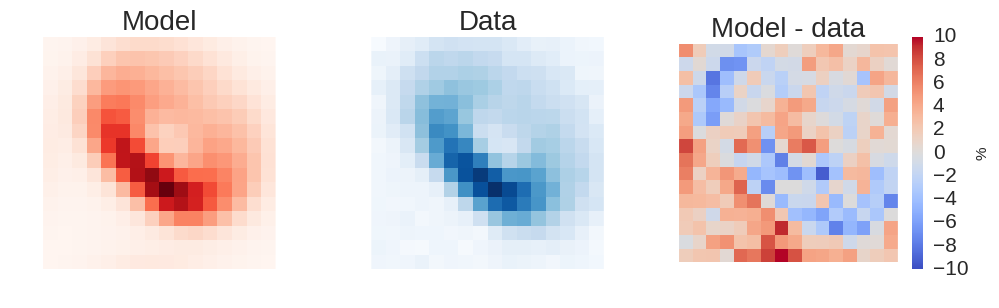

In [13]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(makeStar(*m.args),interpolation='None',cmap=plt.cm.Reds)#,norm=LogNorm(vmin=.0001,vmax=.05)
plt.title('Model',fontsize=20)
plt.axis('off')
plt.subplot(132)
plt.imshow(stamp,interpolation='None',cmap=plt.cm.Blues)#,norm=LogNorm(vmin=.0001,vmax=.05)
plt.title('Data',fontsize=20)
plt.axis('off')
plt.subplot(133)
modelstamp=makeStar(*m.args)
pctdiff=(stamp - modelstamp)/stamp*100.
#g=np.where(abs(stamp)<stamp.max()/200.)
#pctdiff[g]=0
plt.imshow((modelstamp/modelstamp.max()-stamp/stamp.max())*100,cmap=plt.cm.coolwarm,
    interpolation='None',vmin=-10,vmax=10)
plt.title('Model - data',fontsize=20)
plt.axis('off')
plt.colorbar(label='%')
plt.tight_layout

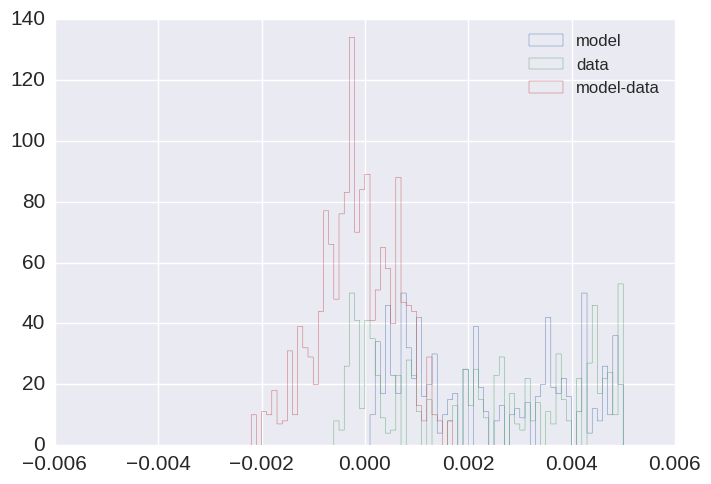

In [14]:
vmax=.005
gpix=np.where(stamp>stamp.std())[0]
plt.hist((modelstamp[gpix]).flatten(),histtype='step',bins=100,range=[-vmax,vmax],label='model')
plt.hist((stamp[gpix]).flatten(),histtype='step',bins=100,range=[-vmax,vmax],label='data')
plt.hist((modelstamp-stamp)[gpix].flatten(),histtype='step',bins=100,range=[-vmax,vmax],label='model-data')
plt.legend(fontsize=12)

In [14]:
m.print_matrix()

+,fwhm,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11
fwhm,1.00,0.60,-0.80,0.85,0.01,-0.10,0.93,-0.77,0.01,-0.11,-0.93
z2,0.60,1.00,-0.33,0.51,0.04,-0.20,0.50,-0.74,-0.10,0.13,-0.59
z3,-0.80,-0.33,1.00,-0.58,-0.02,-0.14,-0.84,0.58,-0.02,0.03,0.74
z4,0.85,0.51,-0.58,1.00,0.01,-0.13,0.84,-0.71,0.02,-0.07,-0.94
z5,0.01,0.04,-0.02,0.01,1.00,-0.00,0.01,-0.01,-0.02,-0.04,-0.01
z6,-0.10,-0.20,-0.14,-0.13,-0.00,1.00,-0.06,0.05,0.38,-0.26,0.12
z7,0.93,0.50,-0.84,0.84,0.01,-0.06,1.00,-0.71,-0.01,0.01,-0.88
z8,-0.77,-0.74,0.58,-0.71,-0.01,0.05,-0.71,1.00,0.07,-0.01,0.75
z9,0.01,-0.10,-0.02,0.02,-0.02,0.38,-0.01,0.07,1.00,-0.06,0.01
z10,-0.11,0.13,0.03,-0.07,-0.04,-0.26,0.01,-0.01,-0.06,1.00,0.05


In [15]:
# load the donut catalog and image
#allframelist=np.sort(glob.glob(thedir+'*whole.fits'))
framenum=17

framename=allframelist[framenum]
print(framename)
image = fits.getdata(framename)
catalog = fits.getdata(framename+'.cat', ext=2)

nsteps=8
nstarsper=10
dx=4000./nsteps*1.
dy=dx
xmins=np.array([i*dx for i in range(nsteps)])
ymins=xmins

/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_117_20170330083732whole.fits


In [ ]:
tstart=time.time()

goodareas=[]
allparams=[]
i=0
for xminfoo in xmins:
    for yminfoo in ymins:
        t1=time.time()
        xmaxfoo,ymaxfoo=xminfoo+dx,yminfoo+dx
        good=np.where((catalog['XWIN_IMAGE']>xminfoo+10) & (catalog['YWIN_IMAGE']>yminfoo+10) &
                      (catalog['XWIN_IMAGE']<xmaxfoo-10) & (catalog['YWIN_IMAGE']<ymaxfoo-10) &
                      (catalog['FLAGS']<2) & (catalog['FLUX_MAX']>500))[0]
        goodsub=good[[random.randint(0,len(good)-1) for jj in range(nstarsper)]]
        goodareas.append(goodsub)
        for ith in goodsub:
            stamp = donut_extractor(ith,catalog,image)
            m.migrad()
            allparams.append(m.args)
        print(i,time.time()-t1)
        i+=1


print(time.time()-tstart)

goodareas=np.ravel(goodareas)
allparams=np.vstack(allparams)

picklesavename=thedir+"zernike_params-"+str(framenum).zfill(2)+'-nsp'+str(nstarsper)+"-pos.pickle"
cPickle.dump([allparams,catalog[goodareas]],open( picklesavename, "wb" ))
print(np.shape(allparams))

0 73.2581539154
1 47.0242991447
2 30.1189491749
3 32.5850729942
4 31.5882828236
5 37.4571888447
6 62.9089231491
7 72.7194519043
8 57.739782095
9 28.7385509014
10 29.2373960018
11 22.045759201
12 38.4700369835
13 36.363309145
14 58.2442610264
15 50.0435340405
16 35.590927124
17 25.7065851688
18 26.2015039921
19 33.1933369637


In [48]:
allframelist

array([ '/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_100_20170330083315whole.fits',
       '/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_101_20170330083330whole.fits',
       '/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_102_20170330083345whole.fits',
       '/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_103_20170330083400whole.fits',
       '/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_104_20170330083415whole.fits',
       '/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_105_20170330083431whole.fits',
       '/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_106_20170330083446whole.fits',
       '/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_107_20170330083501whole.fits',
       '/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_108_20170330083516whole.fits',
       '/home/andrew/Work/ccd/20170330-focus_

In [16]:
import ipyparallel as ipp
from ipyparallel import require
# The Client allows us to use the engines interactively.
# We pass Client the name of the cluster profile we
# are using.
c = ipp.Client()
v = c[:]
#with v.sync_imports():
#    engine = donutengine(**inputDict)
def fit_zernike_to_mosaic(framename):
    import time,random,pyfits,sys
    import numpy as np
    from iminuit import Minuit
    from mydefs import donut_extractor,makeStar
    sys.path.insert(1,'/home/andrew/Work/ccd/wavefronts/')
    from donutengine import donutengine
    inputDict = {"nZernikeTerms":11,"nbin":256,"pixelOversample":16,"iTelescope":3} #was 11,256,16
    engine = donutengine(**inputDict)
    
    from mydefs import iminuit_fit_func
    fwhm,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11=[30]+[0]*10#list(m.args)
    param_0=[20,1,1,0,
             .1,0,.1,0,
             .04,-.03,.14]
    paramlim=np.array([(10,50),(-10,10),(-10,10),(.1,7),
              (-1,1),(-1,1),(-1,1),(-1,1),
              (-.1,.1),(-.1,.1),(-.5,.5)])
    paramerr=np.array([2,3,3,1,
              .5,.5,.5,.5,
              .1,.1,.1])
    m=Minuit(iminuit_fit_func,print_level=0,
             fwhm=fwhm,error_fwhm=paramerr[0],limit_fwhm=paramlim[0],
             z2=z2,error_z2=paramerr[1],limit_z2=paramlim[1],
             z3=z3,error_z3=paramerr[2],limit_z3=paramlim[2],
             z4=z4,error_z4=paramerr[3],limit_z4=paramlim[3],
             z5=z5,error_z5=paramerr[4],limit_z5=paramlim[4],
             z6=z6,error_z6=paramerr[5],limit_z6=paramlim[5],
             z7=z7,error_z7=paramerr[6],limit_z7=paramlim[6],
             z8=z8,error_z8=paramerr[7],limit_z8=paramlim[7],
             z9=z9,error_z9=paramerr[8],limit_z9=paramlim[8],
             z10=z10,error_z10=paramerr[9],limit_z10=paramlim[9],
             z11=z11,error_z11=paramerr[10],limit_z11=paramlim[10])


    #m.print_param()
    
    image = pyfits.getdata(framename)
    catalog = pyfits.getdata(framename+'.cat', ext=2)


    tstart=time.time()

    nsteps=8
    nstarsper=1
    dx=4000./nsteps*1.
    dy=dx
    xmins=np.array([i*dx for i in range(nsteps)])
    ymins=xmins
    goodareas=[]
    allparams=[]
    i=0
    for xminfoo in xmins:
        for yminfoo in ymins:
            t1=time.time()
            xmaxfoo,ymaxfoo=xminfoo+dx,yminfoo+dx
            good=np.where((catalog['XWIN_IMAGE']>xminfoo+10) & (catalog['YWIN_IMAGE']>yminfoo+10) &
                          (catalog['XWIN_IMAGE']<xmaxfoo-10) & (catalog['YWIN_IMAGE']<ymaxfoo-10) &
                          (catalog['FLAGS']<2) & (catalog['FLUX_MAX']>500))[0]
            goodsub=good[[random.randint(0,len(good)-1) for jj in range(nstarsper)]]
            goodareas.append(goodsub)
            for ith in goodsub:
                stamp = donut_extractor(ith,catalog,image)
                m.migrad()
                allparams.append(m.args)
            print(i,time.time()-t1)
            i+=1


    print(time.time()-tstart)

    goodareas=np.ravel(goodareas)
    allparams=np.vstack(allparams)

    picklesavename=thedir+"zernike_params-"+str(framenum).zfill(2)+'-nsp'+str(nstarsper)+"-pos.pickle"
    cPickle.dump([allparams,catalog[goodareas]],open( picklesavename, "wb" ))
    print(np.shape(allparams))

c.ids
allparams=v.map_sync(fit_zernike_to_mosaic, allframelist[-5:])


CompositeError: one or more exceptions from call to method: fit_zernike_to_mosaic
[0:apply]: ImportError: cannot import name iminuit_fit_func
[1:apply]: ImportError: cannot import name iminuit_fit_func
[2:apply]: ImportError: cannot import name iminuit_fit_func
[3:apply]: ImportError: cannot import name iminuit_fit_func
.... 1 more exceptions ...

In [17]:
v.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [25]:
if np.isnan(m.args)[0]==True: print("fuck")

fuck


In [75]:
framename

'/home/andrew/Work/ccd/20170330-focus_curve/ITL-3800C-029_spot_spot_114_20170330083647whole.fits'

In [73]:
%timeit engine = donutengine(**inputDict)

10 loops, best of 3: 24.8 ms per loop


In [66]:
paramlim=np.array([(10,50),(-10,10),(-10,10),(.1,7),
          (-1,1),(-1,1),(-1,1),(-1,1),
          (-.1,.1),(-.1,.1),(-.5,.5)])

param_0=[20,1,1,0,.1,0,.1,0,.04,-.03,.14]
fwhm,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11=[10,-1,-1,4,.1,.1,.1,.1,.04,-.03,0.]#[30]+[0]*10#list(m.args)


m=Minuit(iminuit_fit_func,print_level=0,errordef=1,
             fwhm=fwhm,error_fwhm=paramerr[0],limit_fwhm=paramlim[0],
             z2=z2,error_z2=paramerr[1],limit_z2=paramlim[1],
             z3=z3,error_z3=paramerr[2],limit_z3=paramlim[2],
             z4=z4,error_z4=paramerr[3],limit_z4=paramlim[3],
             z5=z5,error_z5=paramerr[4],limit_z5=paramlim[4],
             z6=z6,error_z6=paramerr[5],limit_z6=paramlim[5],
             z7=z7,error_z7=paramerr[6],limit_z7=paramlim[6],
             z8=z8,error_z8=paramerr[7],limit_z8=paramlim[7],
             z9=z9,error_z9=paramerr[8],limit_z9=paramlim[8],
             z10=z10,error_z10=paramerr[9],limit_z10=paramlim[9],
             z11=z11,error_z11=paramerr[10],limit_z11=paramlim[10])

In [74]:
iminuit_fit_func(fwhm,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11)

17.178393943900542

In [15]:
# load the donut catalog and image
#allframelist=np.sort(glob.glob(thedir+'*whole.fits'))
framenum=19
nsteps=8
nstarsper=10
dx=4000./nsteps*1.
dy=dx
xmins=np.array([i*dx for i in range(nsteps)])
ymins=xmins

for framename in allframelist[-6:]:
    goodareas=[]
    allparams=[]
    i=0
    for xminfoo in xmins:
        for yminfoo in ymins:
            t1=time.time()
            xmaxfoo,ymaxfoo=xminfoo+dx,yminfoo+dx
            good=np.where((catalog['XWIN_IMAGE']>xminfoo+10) & (catalog['YWIN_IMAGE']>yminfoo+10) &
                          (catalog['XWIN_IMAGE']<xmaxfoo-10) & (catalog['YWIN_IMAGE']<ymaxfoo-10) &
                          (catalog['FLAGS']<2) & (catalog['FLUX_MAX']>500))[0]
            if len(good)>nstarsper:
                goodsub=good[[random.randint(0,len(good)-1) for jj in range(nstarsper)]]
                goodareas.append(goodsub)
                for ith in goodsub:
                    engine = donutengine(**inputDict)
                    stamp = donut_extractor(ith,catalog,image)
                    m.migrad()
                    if np.isnan(m.args)==False:
                        allparams.append(m.args)
                print(i,time.time()-t1)
                i+=1


    print(time.time()-tstart)

    goodareas=np.ravel(goodareas)
    allparams=np.vstack(allparams)

    picklesavename=thedir+"zernike_params-"+str(framenum).zfill(2)+'-nsp'+str(nstarsper)+"-pos.pickle"
    cPickle.dump([allparams,catalog[goodareas]],open( picklesavename, "wb" ))
    print(np.shape(allparams))

#for framenum in [14,15,16,17,18,19]:





0 54.0245461464
1 40.3609571457
2 25.0130150318
3 19.3072690964
4 27.9209139347
5 29.4394140244


/home/andrew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    fwhm = +34.853570
      z2 = +nan
      z3 = +1.805352
      z4 = +3.119533
      z5 = +0.083125
      z6 = -0.887704
      z7 = +0.592146
      z8 = -0.513554
      z9 = -0.073726
     z10 = -0.099315
     z11 = +0.216030

/home/andrew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    fwhm = +34.853570
      z2 = +2.851245
      z3 = +1.873721
      z4 = +3.119533
      z5 = +0.083125
      z6 = -0.887704
      z7 = +0.592146
      z8 = -0.513554
      z9 = -0.073726
     z10 = -0.099315
     z11 = +0.216030

/home/andrew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    fwhm = +34.853570
      z2 = +2.851245
      z3 = +1.736896
      z4 = +3.119533
      z5 = +0.08

6 51.1266129017


/home/andrew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    fwhm = +30.000000
      z2 = +0.000000
      z3 = +0.000000
      z4 = +3.550000
      z5 = +0.000000
      z6 = +0.000000
      z7 = +0.000000
      z8 = +0.000000
      z9 = +0.000000
     z10 = +0.000000
     z11 = +0.000000

/home/andrew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    fwhm = +nan
      z2 = +0.000000
      z3 = +0.000000
      z4 = +3.550000
      z5 = +0.000000
      z6 = +0.000000
      z7 = +0.000000
      z8 = +0.000000
      z9 = +0.000000
     z10 = +0.000000
     z11 = +0.000000

/home/andrew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    fwhm = +30.000000
      z2 = +nan
      z3 = +0.000000
      z4 = +3.550000
      z5 = +0.000000
 

7 11.0394239426
8 11.0701951981
9 11.0168149471


ValueError: empty range for randrange() (0,0, 0)

In [91]:
#picklenames=np.sort(glob.glob(thedir+'goodpickles/*.pickle'))##
picklenames=np.sort(glob.glob(thedir+'zernike_params-11*pos.pickle'))
print(picklenames)
paramnames=['fwhm','x tilt','y tilt','focus','x astig.','y astig.',
            'x coma','y coma','x tref.','y tref.','sphere']
len(picklenames),picklenames,paramnames

[ '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-113-nsp10-pos.pickle'
 '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-114-nsp10-pos.pickle'
 '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-115-nsp10-pos.pickle'
 '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-116-nsp10-pos.pickle'
 '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-117-nsp10-pos.pickle'
 '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-118-nsp10-pos.pickle'
 '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-119-nsp10-pos.pickle']


(7,
 array([ '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-113-nsp10-pos.pickle',
        '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-114-nsp10-pos.pickle',
        '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-115-nsp10-pos.pickle',
        '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-116-nsp10-pos.pickle',
        '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-117-nsp10-pos.pickle',
        '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-118-nsp10-pos.pickle',
        '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-119-nsp10-pos.pickle'],
       dtype='|S78'),
 ['fwhm',
  'x tilt',
  'y tilt',
  'focus',
  'x astig.',
  'y astig.',
  'x coma',
  'y coma',
  'x tref.',
  'y tref.',
  'sphere'])

In [92]:
picklesavename=picklenames[0]
allparams,paramcat=cPickle.load(open( picklesavename,"r"))
paramcat=paramcat.flatten()

In [98]:
picklenames[2:]

array([ '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-115-nsp10-pos.pickle',
       '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-116-nsp10-pos.pickle',
       '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-117-nsp10-pos.pickle',
       '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-118-nsp10-pos.pickle',
       '/home/andrew/Work/ccd/20170330-focus_curve/zernike_params-119-nsp10-pos.pickle'],
      dtype='|S78')

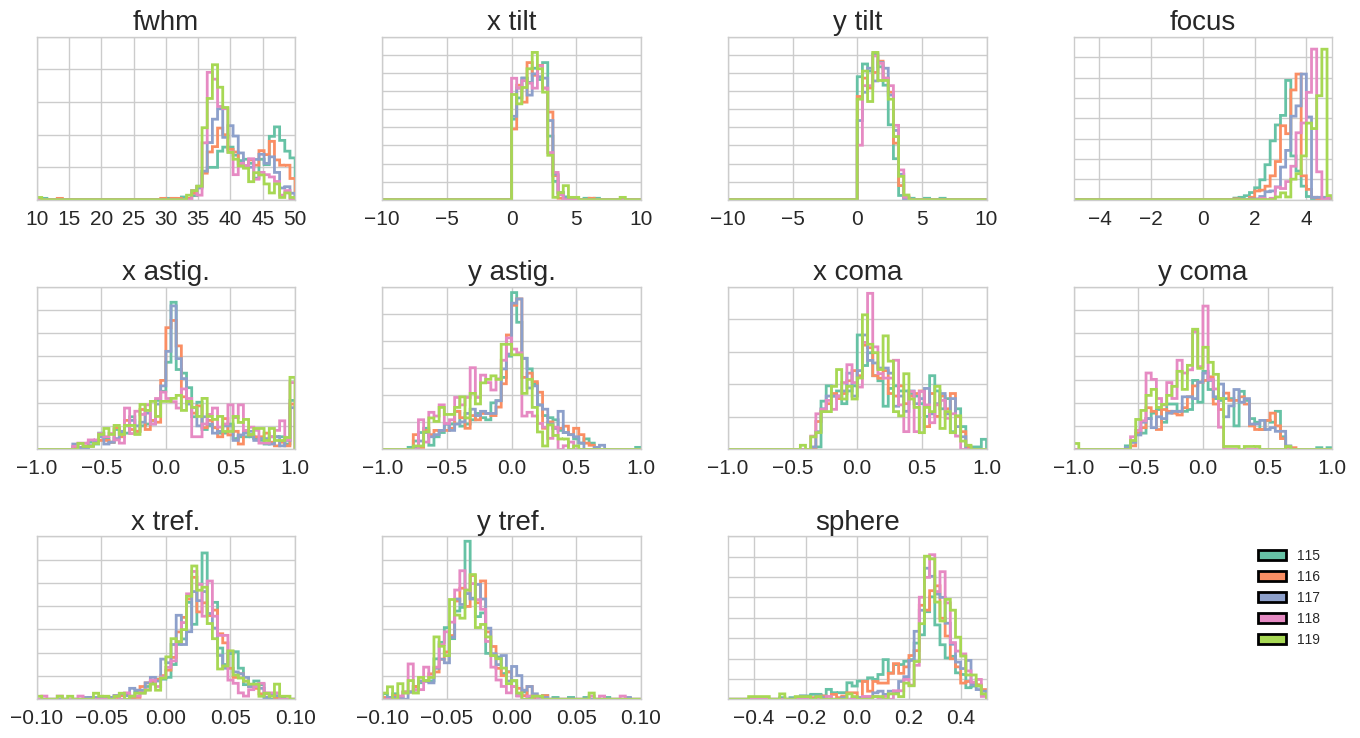

In [100]:
sb.set_style("whitegrid") #whitegrid
colorpalette=cycle(sb.color_palette("Set2",len(picklenames))) #deep,hls (baad), Set2, RdBu_r

#legendtexts=cycle([savename.split('-')[-3] for savename in picklenames])

plt.figure(figsize=(14,10))

for picklename in picklenames[2:]:
    fooparams,paramcat=cPickle.load(open(picklename,"r"))
    legendtext=picklename.split('-')[-3]
    paramcat=paramcat.flatten()
    plotcolor=next(colorpalette)
    for i in range(np.shape(allparams)[1]):
        plt.subplot(4,4,i+1)
        vmin,vmax=paramlim[i][0],paramlim[i][1]
        if i==3: vmin,vmax=-5,5        #np.median(fooparams)-2*np.std(fooparams),np.median(fooparams)+2*np.std(fooparams)
        plt.hist(fooparams[:,i],range=[vmin,vmax],bins=50,normed='True',
                 histtype='step',linewidth=2,color=plotcolor)
        plt.title(paramnames[i],fontsize=20)
        #plt.axhline(paramlim[i][0],color='k',linestyle='--')
        #plt.axhline(paramlim[i][1],color='k',linestyle='--')
        plt.xlim(vmin,vmax)
        plt.tick_params(axis='both', which='both', bottom='on', top='off', 
                        labelbottom='on', right='off', left='off', labelleft='off')
    plt.subplot(4,4,12)
    plt.hist([0,1,2,3],linewidth=2,color=plotcolor,label=picklename.split('-')[-3])
plt.subplot(4,4,12)
plt.axis([-100,-90,-100,-90])
plt.axis('off')
plt.legend(fontsize=10)
plt.tight_layout()
#plt.savefig(thedir+str(framenum)+'.png')

In [25]:
colorpalette=cycle(sb.color_palette("Set2",len(picklenames)))

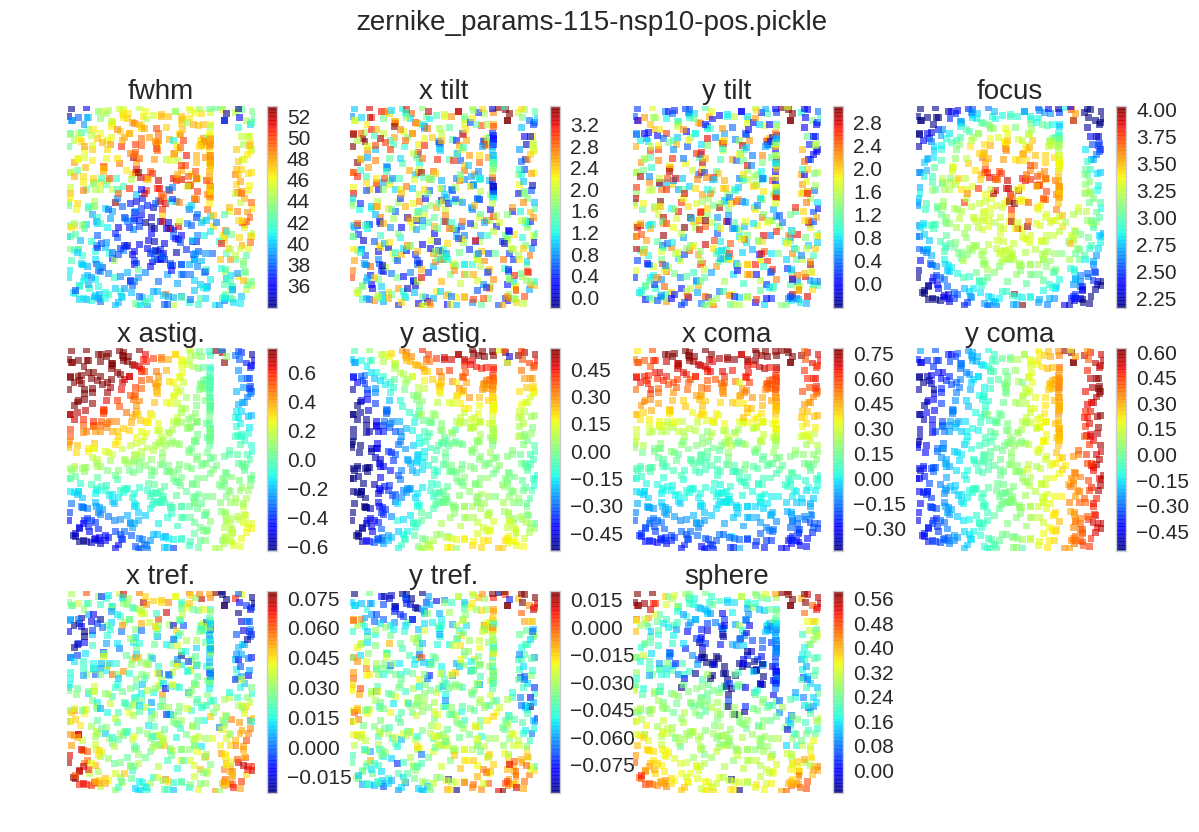

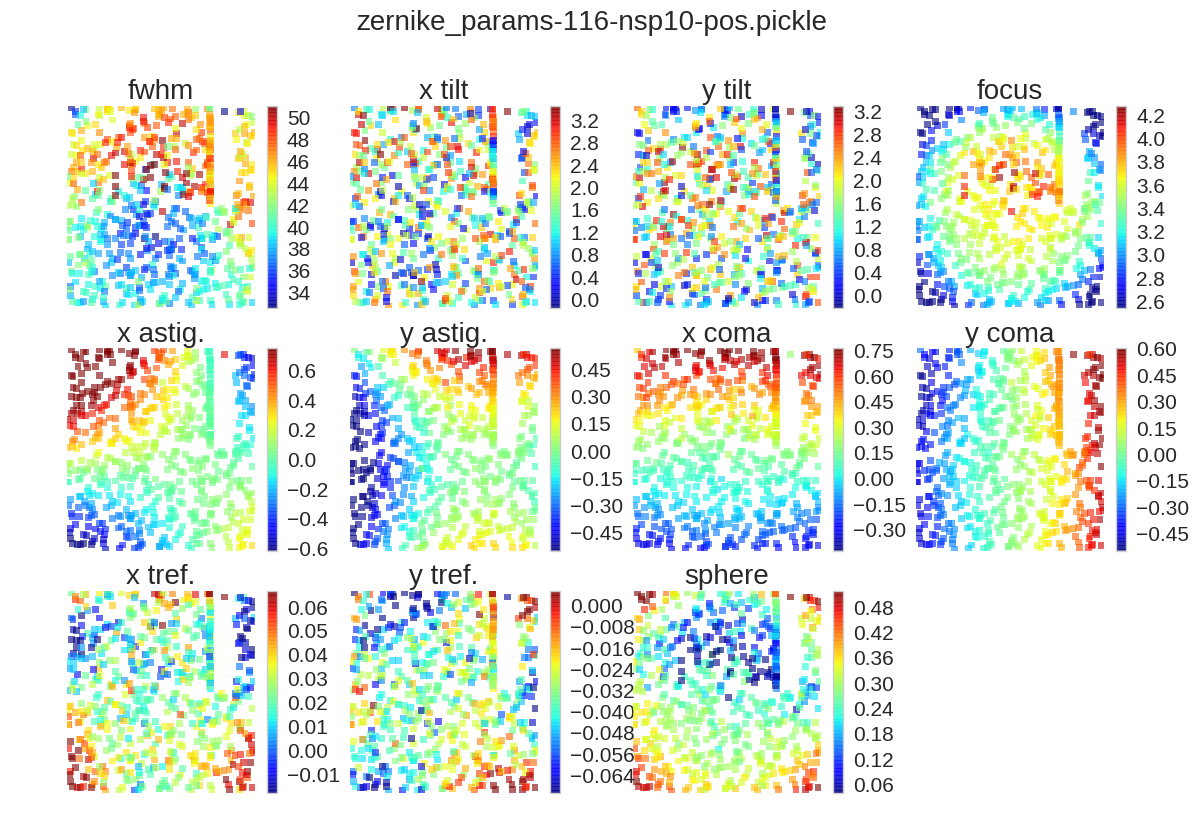

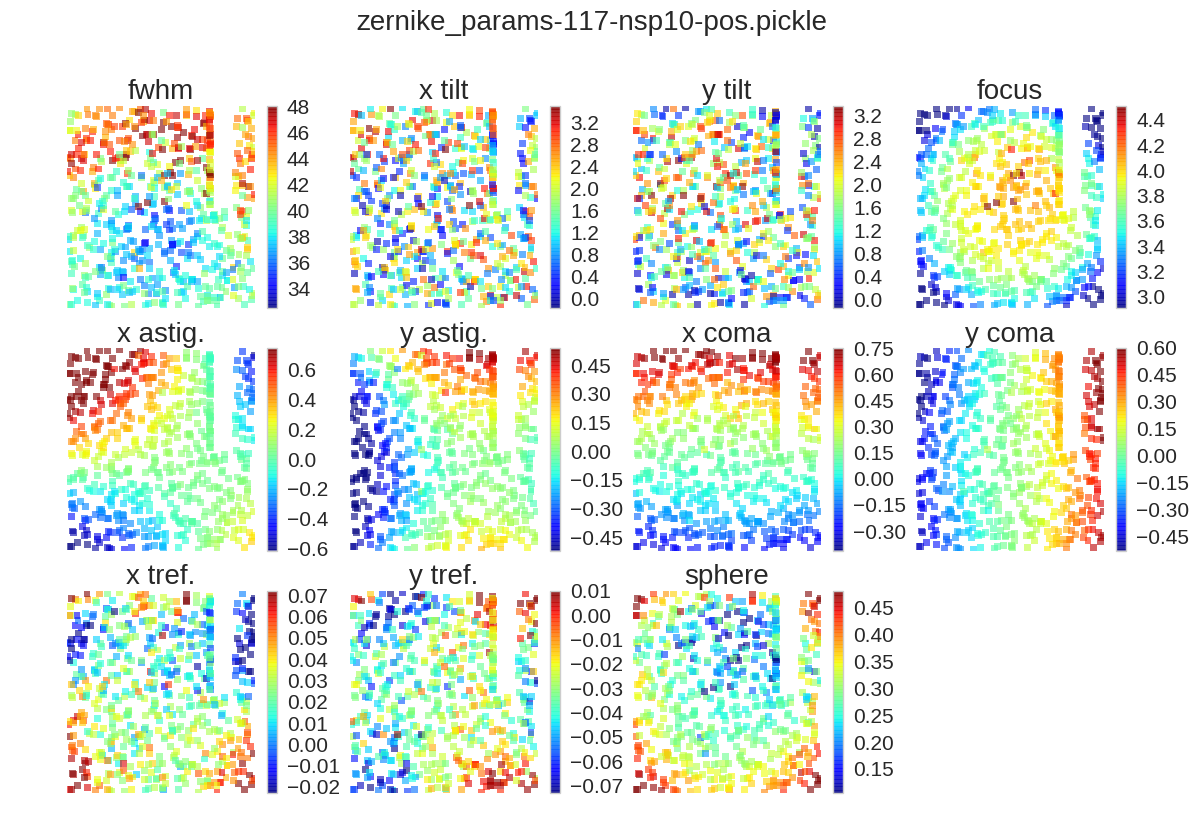

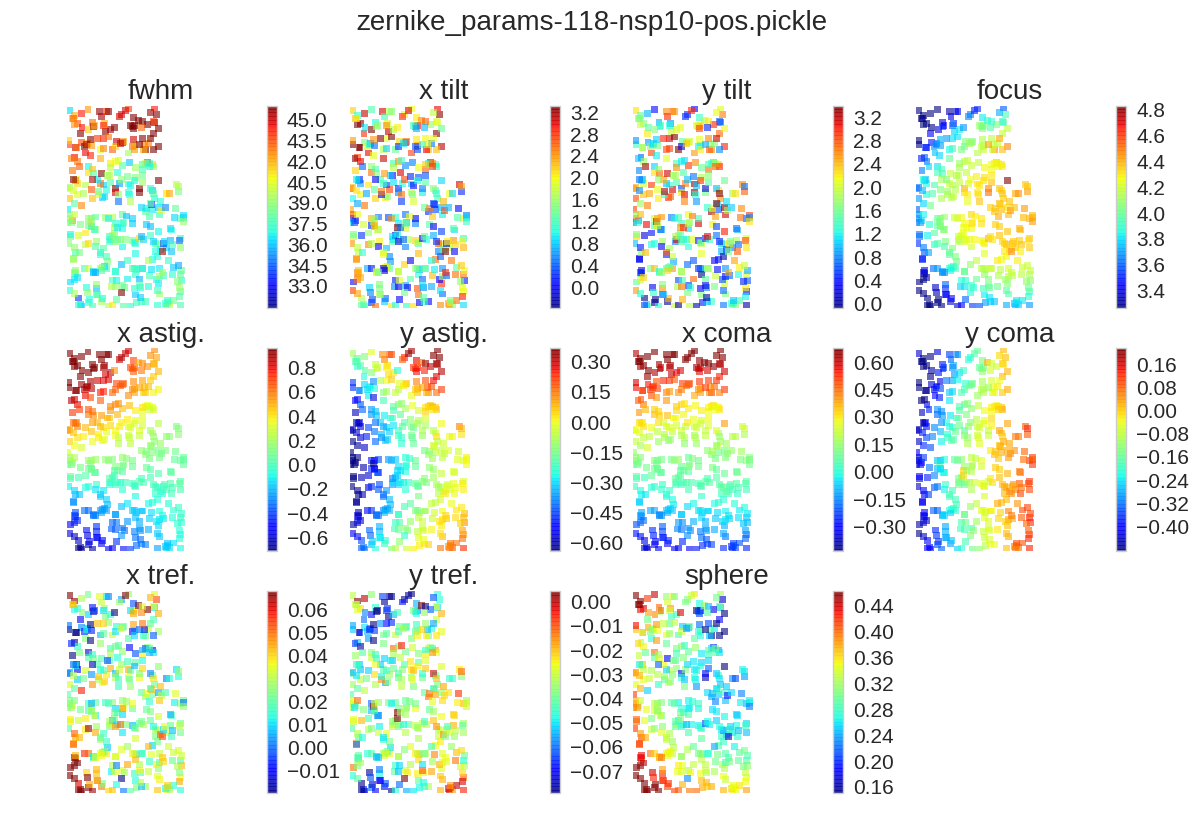

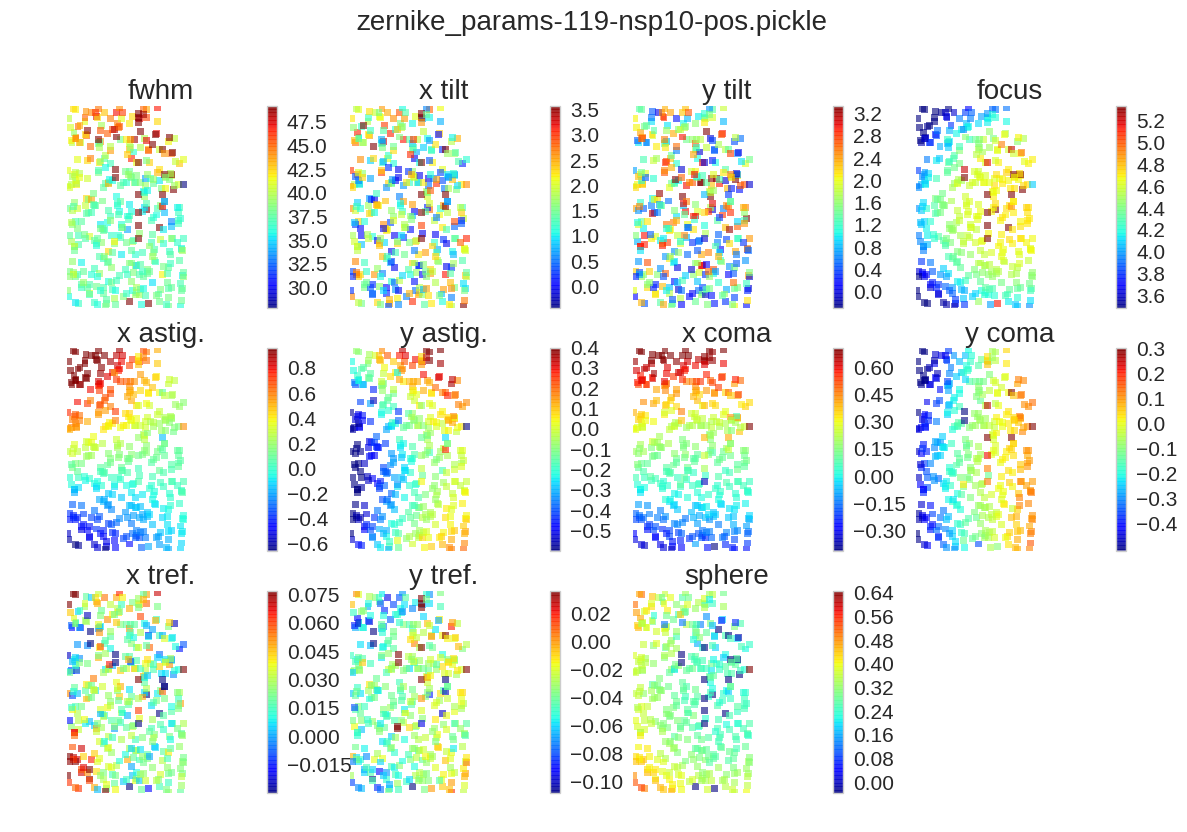

In [103]:
colorpalette=cycle([plt.cm.Reds,plt.cm.Blues])

for picklename in picklenames[2:]:
    allparams,paramcat=cPickle.load(open(picklename,"r"))
    paramcat=paramcat.flatten()
    plotcolor=next(colorpalette)
    plt.figure(figsize=(14,12))
    for i in range(np.shape(allparams)[1]):
        plt.subplot(4,4,i+1)
        fooxc,fooyc=paramcat['XWIN_IMAGE'],paramcat['YWIN_IMAGE']
        fooparams=allparams[:,i]
        vmin,vmax=np.median(fooparams)-2*np.std(fooparams),np.median(fooparams)+2*np.std(fooparams)
        plt.scatter(fooxc,fooyc, c=fooparams,marker='s',alpha=.6,s=25,lw=0,label='ad data',
                    vmin=vmin,vmax=vmax,cmap=plt.cm.jet)
        plt.axis([0,4e3,0,4e3])
        plt.axis('off')
        plt.colorbar()
        #pl(np.arange(0,4e3,3))
        plt.title(paramnames[i],fontsize=20)
    plt.suptitle(picklename.split('/')[-1])#+'  '+next(legendtexts))
#plt.subplots_adjust(hspace=-.7,wspace=-.7)
#plt.tight_layout()
#plt.savefig(thedir+str(framenum)+'abmap.png')

UnboundLocalError: local variable 'ymin' referenced before assignment

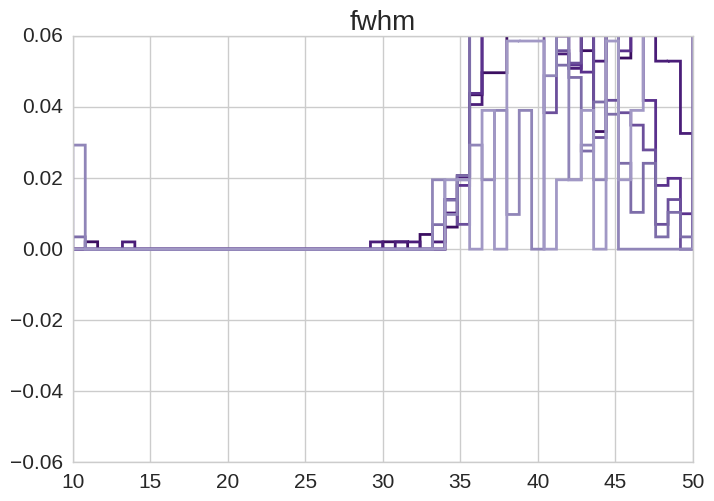

In [105]:
picklenames=np.sort(glob.glob(thedir+'*.pickle'))##
paramnum=0
colorpalette=cycle(sb.color_palette("PuOr_r",len(picklenames)))
for picklename in picklenames[2:]:
    fooparams,paramcat=cPickle.load(open(picklename,"r"))
    paramcat=paramcat.flatten()
    vmin,vmax=paramlim[paramnum][0],paramlim[paramnum][1]
    if paramnum==3: vmin,vmax=-5,5
    plt.hist(fooparams[:,paramnum],range=[vmin,vmax],bins=50,normed='True',linewidth=2,
            histtype='step',label=picklename.split('/')[-1],color=next(colorpalette))
    plt.title(paramnames[paramnum],fontsize=20)
plt.legend(fontsize=12)

In [108]:
def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    coeff, residues, rank, singval = np.linalg.lstsq(G, z)
    return coeff,residues,rank,singval

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:1535: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


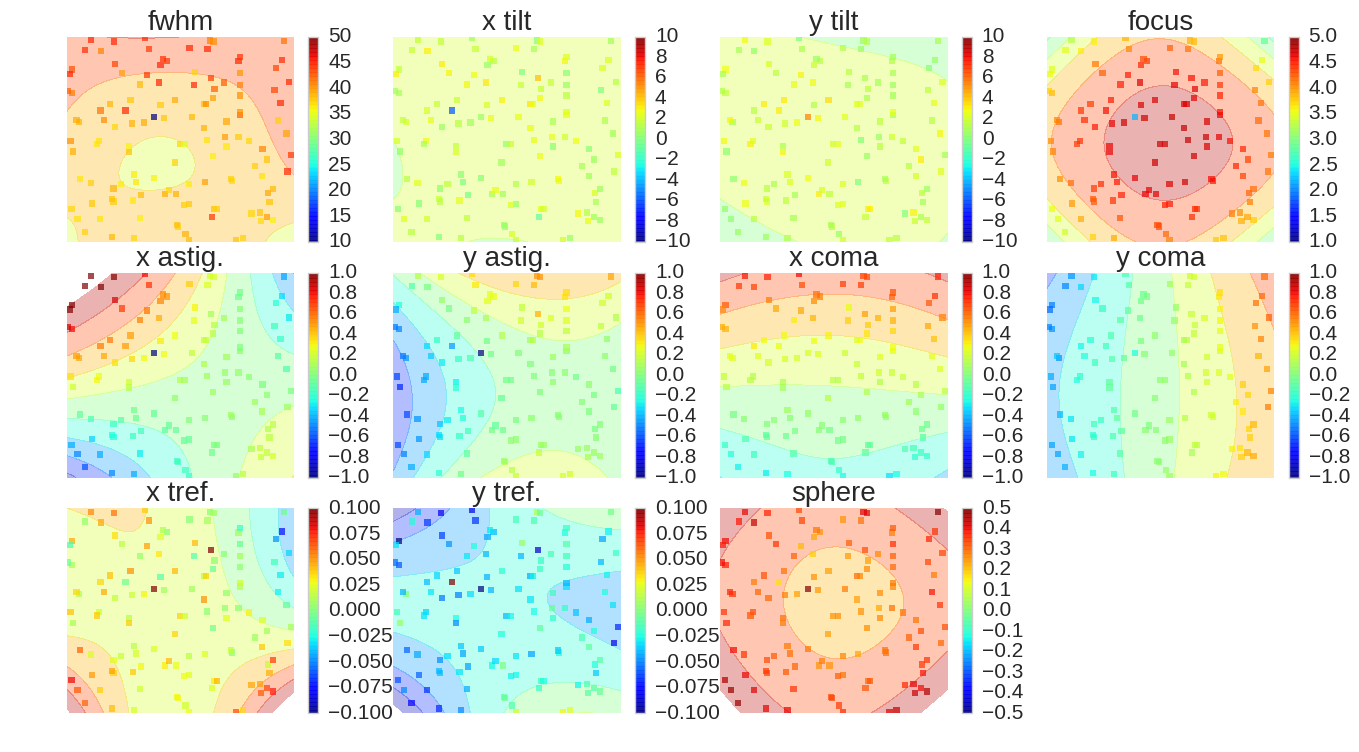

In [109]:

polyorder=2
nx, ny = 100,100
xx, yy = np.meshgrid(np.linspace(0, 4000, nx), 
                     np.linspace(0, 4000, ny))

plt.figure(figsize=(14,10))
for picklename in picklenames[2:]:
    plt.clf()
    allparams,paramcat=cPickle.load(open(picklename,"r"))
    paramcat=paramcat.flatten()
    allmodels=[]
    
    for i in range(np.shape(allparams)[1]):
        plt.subplot(4,4,i+1)
        fooparams=allparams[:,i].copy()
        z=fooparams
        vmin,vmax=paramlim[i][0],paramlim[i][1]#np.median(fooparams)-2.5*np.std(fooparams),np.median(fooparams)+2.5*np.std(fooparams)
        if i==3: vmin,vmax=1,5
        fooxc,fooyc=paramcat['XWIN_IMAGE'].flatten(),paramcat['YWIN_IMAGE'].flatten()
        m,res,rank,sval = polyfit2d(fooxc,fooyc,z,order=polyorder)
        allmodels.append(m)
        zz = polyval2d(xx, yy, m)
        plt.contourf(xx,yy,zz,alpha=.3,vmin=vmin,vmax=vmax,lw=3,levels=np.linspace(vmin,vmax,10),
                     label='poly model',cmap=plt.cm.jet)
        plt.scatter(fooxc,fooyc, c=allparams[:,i],marker='s',alpha=.7,s=20,lw=0,label='ad data',
                   vmin=vmin,vmax=vmax,cmap=plt.cm.jet)
        plt.colorbar()
        plt.axis([0,4e3,0,4e3])
        plt.axis('off')
        plt.title(paramnames[i],fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(hspace=.15,wspace=.15)
    plt.savefig(thedir+picklename.split('-')[-2]+'abmap-model.png')
    #plt.savefig(thedir+str(framenum)+'abmap-model.png')

In [118]:
np.shape(allparams)

(128, 11)

In [84]:
#making higher resolution/different size stamps for plotting
hiresinputDict = {"nZernikeTerms":11,"nbin":512,"pixelOversample":16,"iTelescope":3} #was 11,256,16
engine = donutengine(**inputDict)
modelstamps=[]
for i in range(nsteps**2):
    medparams=np.median(allparams[i*nstarsper:(i+1)*nstarsper],axis=0).copy()
    modelstamps.append(makeStar(*medparams))

#engine = donutengine(**inputDict)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [85]:
np.shape(modelstamp)

(16, 16)

/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:943: UserWarning: Warning: converting a masked element to nan.
  vmin = float(vmin)
/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:944: UserWarning: Warning: converting a masked element to nan.
  vmax = float(vmax)


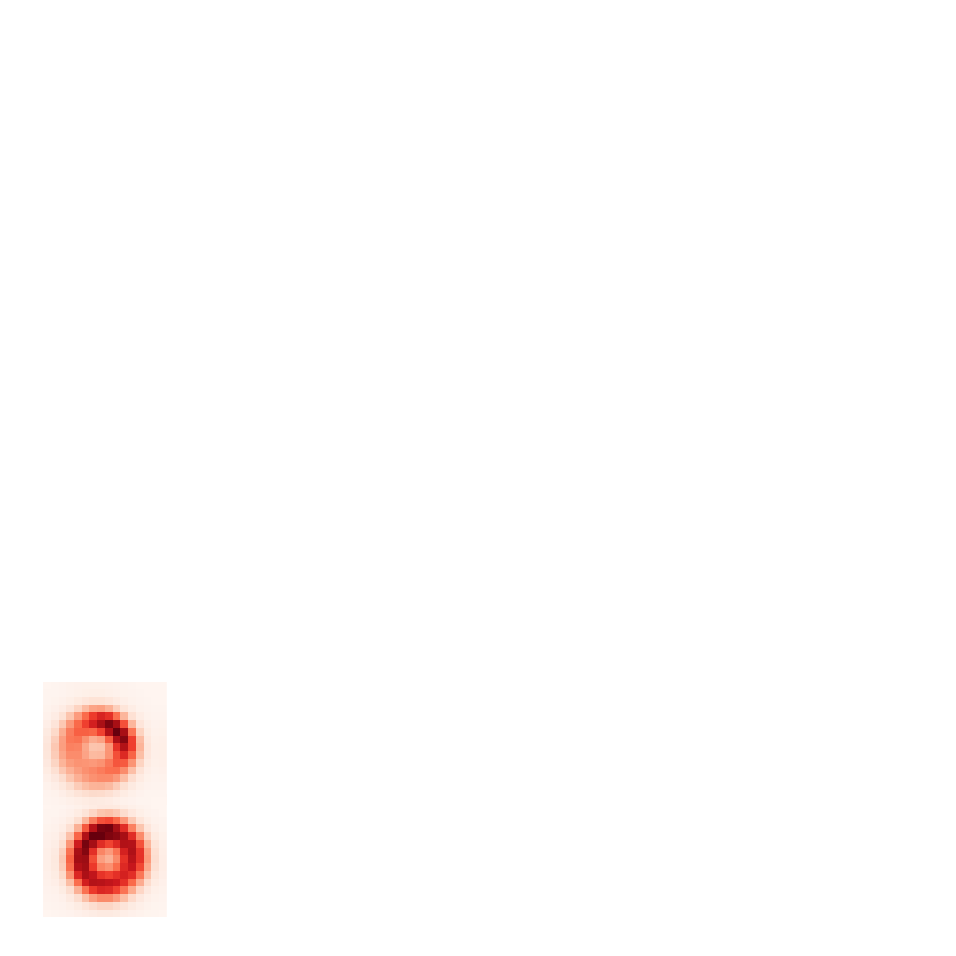

In [86]:
plt.figure(figsize=(10,10))
plotlocs=np.hstack([[nsteps**2-jj*(nsteps)+ii for jj in range(1,nsteps+1)] for ii in range(1,nsteps+1)])
for i in range(nsteps**2):
    plt.subplot(nsteps,nsteps,plotlocs[i])
    modelstamp=modelstamps[i]
    plt.imshow(modelstamp,interpolation='None',origin='lower',cmap="Reds")#,norm=LogNorm())
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(hspace=-.1,wspace=-.1)

In [111]:
len(goodareas)

128

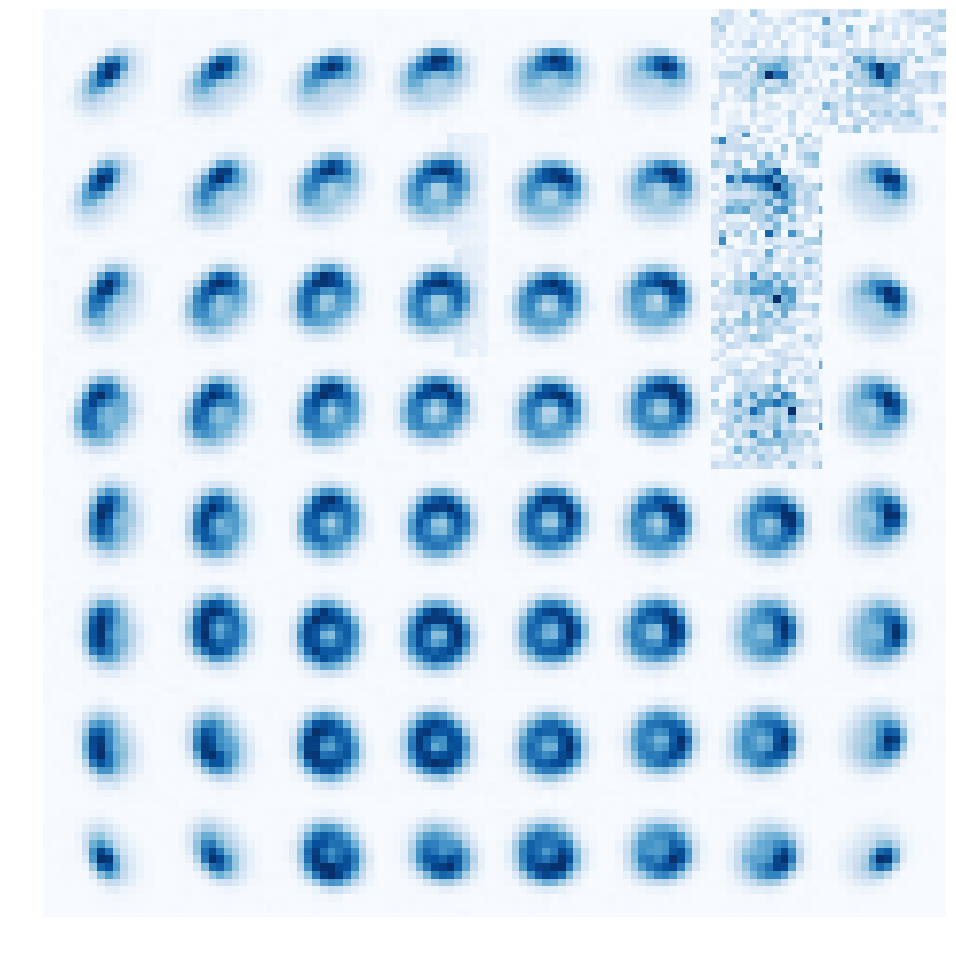

In [123]:
plt.figure(figsize=(10,10))
plotlocs=np.hstack([[nsteps**2-jj*(nsteps)+ii for jj in range(1,nsteps+1)] for ii in range(1,nsteps+1)])
for i in range(nsteps**2):
    plt.subplot(nsteps,nsteps,plotlocs[i])
    ith=goodareas[::nstarsper][i]
    stamp = donut_extractor(ith,catalog,image)
    plt.imshow(stamp,interpolation='None',origin='lower',vmin=0,cmap="Blues")#,norm=LogNorm())
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(hspace=-.1,wspace=-.1)

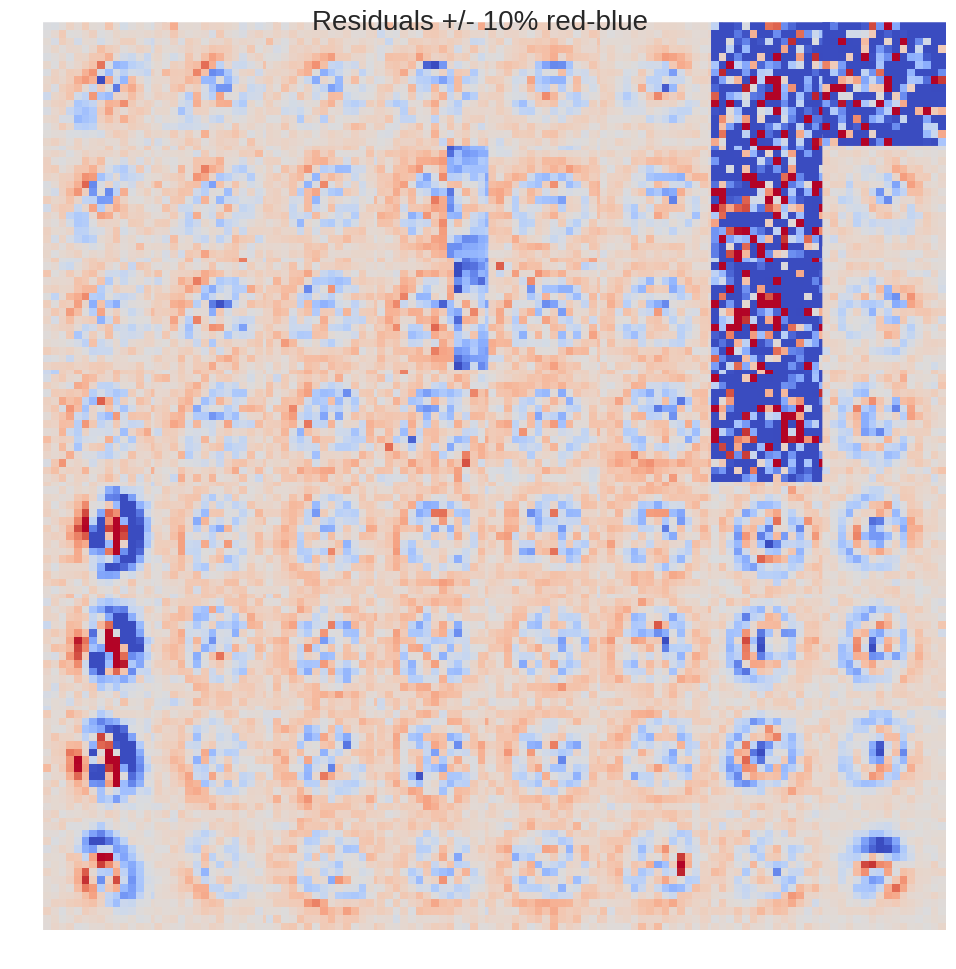

In [127]:
plt.figure(figsize=(10,10))
plotlocs=np.hstack([[nsteps**2-jj*(nsteps)+ii for jj in range(1,nsteps+1)] for ii in range(1,nsteps+1)])
for i in range(nsteps**2):
    plt.subplot(nsteps,nsteps,plotlocs[i])
    medparams=np.median(allparams[i*nstarsper:(i)*nstarsper],axis=0)#allparams[i*nstarsper].copy()#
    #medparams[1:3]=allparams[i*nstarsper][1:3]
    modelstamp=makeStar(*allparams[i*nstarsper])#medparams)#
    ith=goodareas[::nstarsper][i]
    stamp = donut_extractor(ith,catalog,image)
    plt.imshow((modelstamp/modelstamp.max()-stamp/stamp.max())*100.,
               interpolation='None',origin='lower',vmin=-10,vmax=10,cmap=plt.cm.coolwarm)#,norm=LogNorm())
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Residuals +/- 10% red-blue')
plt.subplots_adjust(hspace=-.1,wspace=-.1)


2.3898421789757087

/home/andrew/Work/ccd/wavefronts/psf_evaluator.py:76: RuntimeWarning: invalid value encountered in double_scalars
  = adaptive_moments(stamp, **self.adaptive_moments_kwargs)


[-500.0, 4000.0, -500.0, 4000.0]

/usr/local/lib/python2.7/dist-packages/matplotlib/quiver.py:698: RuntimeWarning: divide by zero encountered in true_divide
  shrink = length / minsh
/usr/local/lib/python2.7/dist-packages/matplotlib/quiver.py:699: RuntimeWarning: invalid value encountered in multiply
  X0 = shrink * X0[np.newaxis, :]
/usr/local/lib/python2.7/dist-packages/matplotlib/quiver.py:700: RuntimeWarning: invalid value encountered in multiply
  Y0 = shrink * Y0[np.newaxis, :]


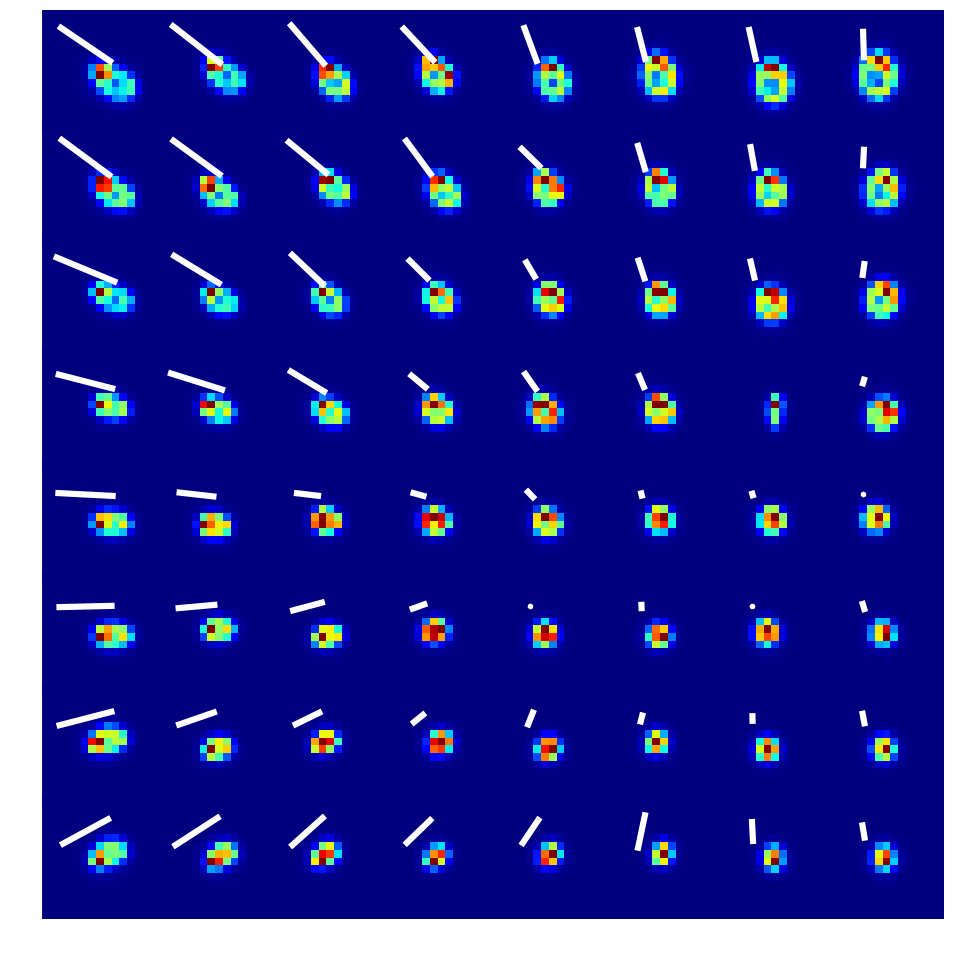

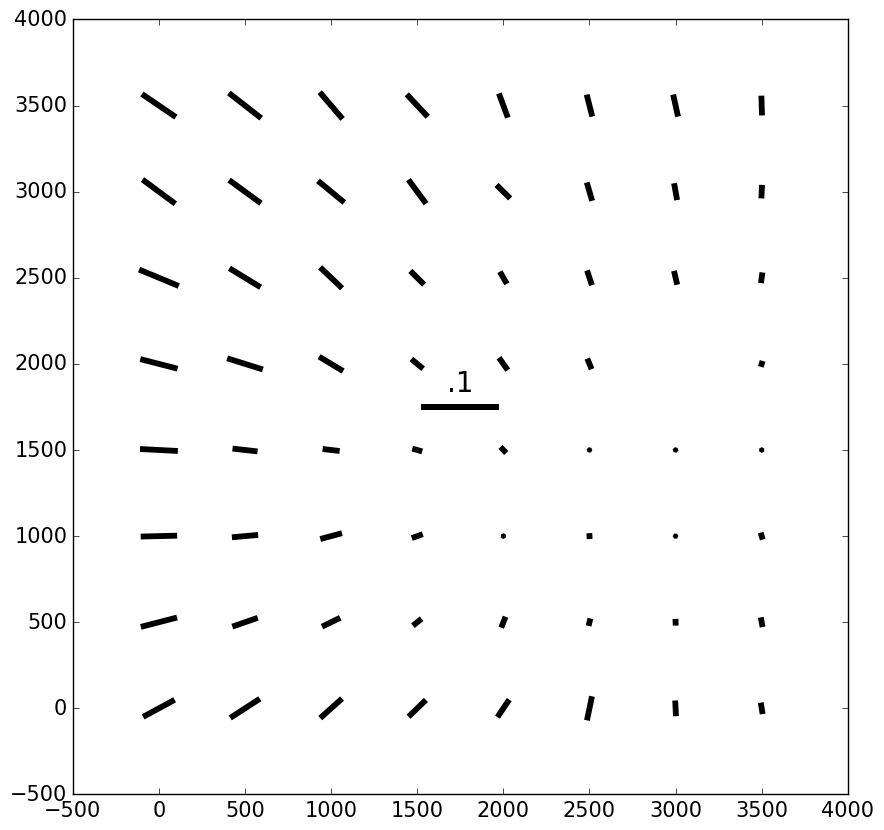

In [41]:
plusfocus=-1.#-np.median(allparams[:,3])#3.

plt.figure(figsize=(10,10))
plotlocs=np.hstack([[nsteps**2-jj*(nsteps)+ii for jj in range(1,nsteps+1)] for ii in range(1,nsteps+1)])
ME=Moment_Evaluator()#,guess_sig=.1
allc1,allc2=[],[]
for i in range(nsteps**2):
    plt.subplot(nsteps,nsteps,plotlocs[i])
    focusparams=allparams[i].copy()
    focusparams[3]+=plusfocus
    modelstamp=makeStar(*focusparams)
    outD = ME(modelstamp)
    #print(outD['x2'],outD['y2'])
    c1,c2=(outD['x2'] - outD['y2'])/(outD['x2']+outD['y2']),(2.*outD['xy'])/(outD['x2']+outD['y2'])
    allc1.append(c1)
    allc2.append(c2)
    plt.imshow(modelstamp,interpolation='None',origin='lower')#,norm=LogNorm())
    plt.axis('off')
    tempu,tempv=np.sqrt(c1**2+c2**2)*np.cos(.5*np.arctan2(c2,c1)),np.sqrt(c1**2+c2**2)*np.sin(.5*np.arctan2(c2,c1))
    plt.quiver(5,11,tempu*10,tempv*10,headaxislength=0,headlength=0,pivot='mid',alpha=1,color='w',scale=10,width=.05)


plt.tight_layout()
plt.subplots_adjust(hspace=-.1,wspace=-.1)


mx,my=np.meshgrid(xmins,xmins)#
plotfoos=np.arange(1,nsteps**2+1)#plotlocs.copy()#
e1all=np.array([allc1[plotloc-1] for plotloc in plotfoos])
e2all=np.array([allc2[plotloc-1] for plotloc in plotfoos])

sepp=np.sqrt(e1all**2+e2all**2)
allphi=.5*np.arctan2(e2all,e1all)

u=sepp*np.cos(allphi)
v=sepp*np.sin(allphi)

plt.figure(figsize=(10,10))#my,mx,
q=plt.quiver(my,mx,u.reshape((nsteps,nsteps)),v.reshape((nsteps,nsteps)),
           headaxislength=0,headlength=0,pivot='mid',alpha=1,scale=10)#,scale=.005
plt.quiverkey(q,.5,.5,1,label='.1')
plt.axis([xmins[0]-xmins[1],xmins[-1]+xmins[1],xmins[0]-xmins[1],xmins[-1]+xmins[1]])
#plt.title(picklename,fontsize=25)

In [42]:
# load the donut catalog and image
#allframelist=np.sort(glob.glob(thedir+'*whole.fits'))
framenum=9

framename=allframelist[framenum]
print(framename)
image = fits.getdata(framename)
catalog = fits.getdata(framename+'.cat', ext=2)

nsteps=8
nsteps=8
nstarsper=1
dx=4000./nsteps*1.
dy=dx
xmins=np.array([i*dx for i in range(nsteps)])
ymins=xmins

/home/andrew/Work/ccd/20161118-focuscurve/ITL-3800C-029_spot_spot_109_20161118111935whole.fits


3.79921007156


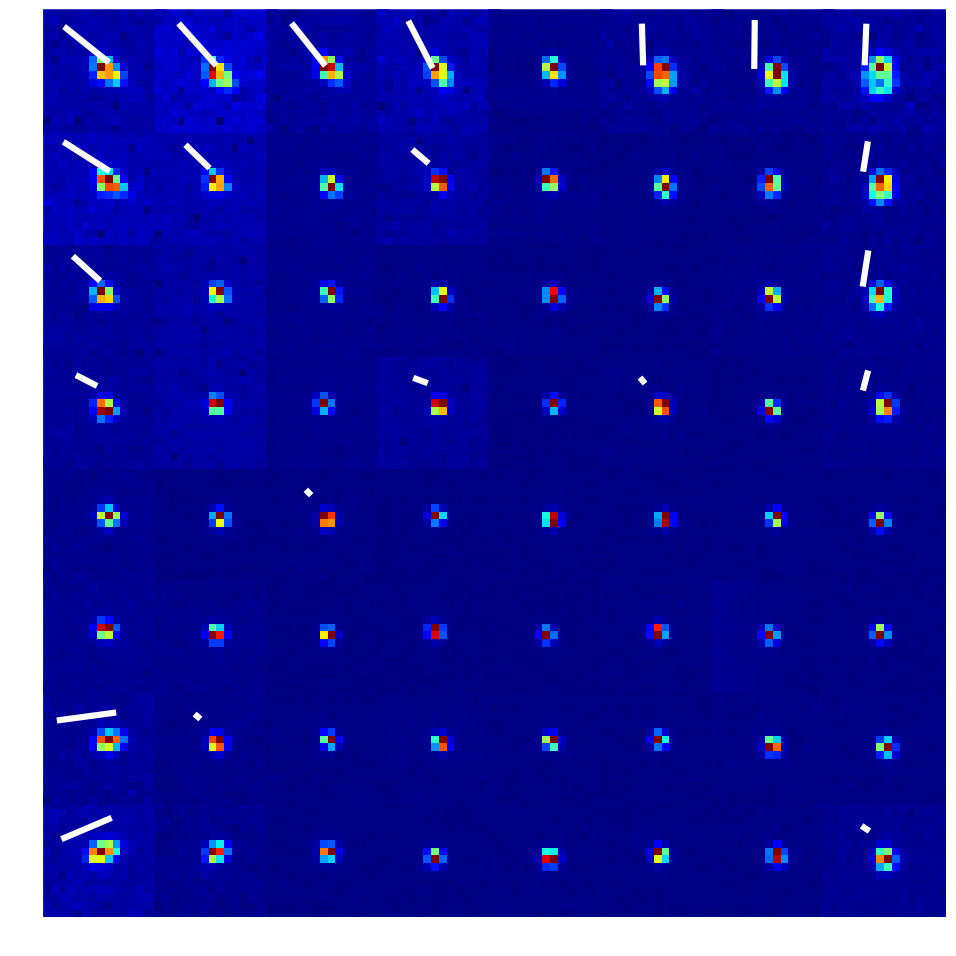

In [79]:
tstart=time.time()

goodareas=[]
dataparams=[]
datac1,datac2=[],[]
ME=Moment_Evaluator()#Moment_Evaluator(epsilon=1e-2,convergence_factor=1e-3,guess_sig=1.8,num_iter_max=100,bound_correct_wt=.0825,verbose=False)
plt.figure(figsize=(10,10))
i=0
for xminfoo in xmins:
    for yminfoo in ymins:
        plt.subplot(nsteps,nsteps,plotlocs[i])
        xmaxfoo,ymaxfoo=xminfoo+dx,yminfoo+dx
        good=np.where((catalog['XWIN_IMAGE']>xminfoo+10) & (catalog['YWIN_IMAGE']>yminfoo+10) &
                      (catalog['XWIN_IMAGE']<xmaxfoo-10) & (catalog['YWIN_IMAGE']<ymaxfoo-10) &
                      (catalog['FLAGS']==0) & (catalog['FLUX_MAX']>500))[0]
        ith=good[random.randint(0,len(good)-1)]# for jj in range(nstarsper)]]
        goodareas.append(ith)
        stamp = donut_extractor(ith,catalog,image)
        outD = ME(stamp)
        #print(outD['x2'],outD['y2'])
        c1,c2=(outD['x2'] - outD['y2'])/(outD['x2']+outD['y2']),(2.*outD['xy'])/(outD['x2']+outD['y2'])
        datac1.append(c1)
        datac2.append(c2)
        plt.imshow(stamp,interpolation='None',origin='lower',cmap=plt.cm.jet)#,norm=LogNorm())
        plt.axis('off')
        tempu,tempv=np.sqrt(c1**2+c2**2)*np.cos(.5*np.arctan2(c2,c1)),np.sqrt(c1**2+c2**2)*np.sin(.5*np.arctan2(c2,c1))
        plt.quiver(5,11,tempu*10,tempv*10,headaxislength=0,headlength=0,pivot='mid',alpha=1,color='w',scale=10,width=.05)
        i+=1

plt.tight_layout()
plt.subplots_adjust(hspace=-.1,wspace=-.1)

print(time.time()-tstart)


In [75]:
mx,my=np.meshgrid(xmins,xmins)#
plotfoos=np.arange(1,nsteps**2+1)#plotlocs.copy()#
e1data=np.array([datac1[plotloc-1] for plotloc in plotfoos])
e2data=np.array([datac2[plotloc-1] for plotloc in plotfoos])

seppdata=np.sqrt(e1data**2+e2data**2)
phidata=.5*np.arctan2(e2all,e1all)

udata=seppdata*np.cos(phidata)
vdata=seppdata*np.sin(phidata)

plt.figure(figsize=(10,10))#my,mx,
q=plt.quiver(my,mx,udata.reshape((nsteps,nsteps)),vdata.reshape((nsteps,nsteps)),
           headaxislength=0,headlength=0,pivot='mid',alpha=1,scale=10,label='data')#,scale=.005

e1all=np.array([allc1[plotloc-1] for plotloc in plotfoos])
e2all=np.array([allc2[plotloc-1] for plotloc in plotfoos])

sepp=np.sqrt(e1all**2+e2all**2)
allphi=.5*np.arctan2(e2all,e1all)

u=sepp*np.cos(allphi)
v=sepp*np.sin(allphi)

#plt.figure(figsize=(10,10))#my,mx,
q=plt.quiver(my+100,mx+100,u.reshape((nsteps,nsteps)),v.reshape((nsteps,nsteps)),
           headaxislength=0,headlength=0,pivot='mid',alpha=1,scale=10,color='r',label='model prediction')#,scale=.005
plt.quiverkey(q,.5,.5,1,label='.1')
plt.axis([xmins[0]-xmins[1],xmins[-1]+xmins[1],xmins[0]-xmins[1],xmins[-1]+xmins[1]])
plt.legend(fontsize=12)
#plt.title(picklename,fontsize=25)

NameError: name 'datac1' is not defined

(array([ 14.,   6.,  12.,   4.,   6.,   4.,   6.,   3.,   2.,   6.]),
 array([-1.57079633, -1.25663706, -0.9424778 , -0.62831853, -0.31415927,
         0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,
         1.57079633]),
 <a list of 1 Patch objects>)

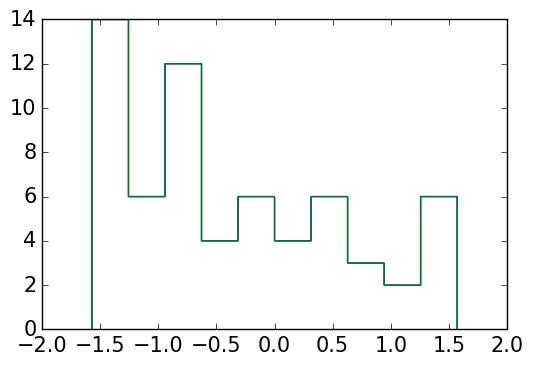

In [669]:
plt.hist(phidata,range=[-np.pi/2.,np.pi/2.],histtype='step')
plt.hist(allphi,range=[-np.pi/2.,np.pi/2.],histtype='step')

# Testing adaptive moments on data, looking at serial CTE

In [52]:
def calc_firstmoms(img,coord,winsize,thresh,gwin_sig):
    "Calculates the x, y, xy, and radial second moments of the subimg, given the image and its centroid" 
    xc,yc=coord
    xmom,ymom=0.,0.
    thesum=0.
    
    i0=int(round(xc)-winsize)
    j0=int(round(yc)-winsize)
    #print i0,j0,winsize
    for i in range(2*winsize):
        for j in range(2*winsize): #+1?
            if img[j0+j,i0+i]>thresh:
                gwt=np.exp(-((xc-(i0+i))**2+(yc-(j0+j))**2)/(2.*gwin_sig**2))
                thesum+=img[j0+j,i0+i]*gwt
                xmom+=img[j0+j,i0+i]*((i0+i))*gwt
                ymom+=img[j0+j,i0+i]*((j0+j))*gwt
    if thesum >0:
        xmom= xmom/thesum
        ymom= ymom/thesum
    else:
        rmom=xmom=ymom=xymom=1.
    return xmom, ymom

def calc_secmoms_gwin(img,coord,winsize,thresh,gwin_sig):
    "Calculates the x, y, xy, and radial second moments of the subimg, given the image and its centroid" 
    xc,yc=coord
    r2mom,x2mom,y2mom,xy2mom=0.,0.,0.,0.
    thesum=0.
    
    i0=int(round(xc)-winsize)
    j0=int(round(yc)-winsize)
    #print i0,j0,winsize
    for i in range(2*winsize):
        for j in range(2*winsize): #+1?
            if img[j0+j,i0+i]>thresh:
                gwt=np.exp(-((xc-(i0+i))**2+(yc-(j0+j))**2)/(2.*gwin_sig**2))
                thesum+=img[j0+j,i0+i]*gwt
                r2mom+=img[j0+j,i0+i]*((xc-(i0+i))**2+(yc-(j0+j))**2)*gwt
                x2mom+=img[j0+j,i0+i]*(xc-(i0+i))**2*gwt
                y2mom+=img[j0+j,i0+i]*(yc-(j0+j))**2*gwt
                xy2mom+=img[j0+j,i0+i]*(((i0+i)-xc)*((j0+j)-yc))*gwt
    if thesum >0:
        rmom = np.sqrt(.5*(r2mom/thesum))
        xmom= np.sqrt(x2mom/thesum)
        ymom= np.sqrt(y2mom/thesum)
        xyz=xy2mom/thesum
        xymom= xyz/abs(xyz)*np.sqrt(abs(xyz))
    else:
        rmom=xmom=ymom=xymom=1.
    return rmom, xmom, ymom, xymom

def median_xy(xin,yin,nxbins):
    xmin,xmax=xin.min(),xin.max()
    xbin=np.linspace(xmin,xmax,nxbins+1)
    ymed=np.zeros(nxbins)
    num_objs=np.zeros(nxbins)
    for i in range(nxbins):
        gd=np.where((xin>xbin[i]) & (xin<xbin[i+1]))
        ymed[i]=np.median(yin[gd])
        num_objs[i]=len(gd[0])
    return np.array(xbin[:-1]),ymed,num_objs

In [53]:
Moment_Evaluator?

In [48]:
import pyfits

In [50]:
ME=Moment_Evaluator(bound_correct_wt = .01,epsilon=1e-2,convergence_factor=1e-3,guess_sig=1.85,num_iter_max=100,verbose=False)#bound_correct_wt=.0825
#bound_correct_wt .01 no good
ME.adaptive_moments_kwargs

{'bound_correct_wt': 0.01,
 'convergence_factor': 0.001,
 'epsilon': 0.01,
 'guess_sig': 1.85,
 'num_iter_max': 100,
 'verbose': False}

In [54]:
xminfoo,xmaxfoo,yminfoo,ymaxfoo=100,3980,1750,1950
framenames=np.sort(glob.glob(thedir+'../20161117-3micron_CTE/ITL-3800C-029_spot_spot_2??_20161117*whole.fits'))
#framename=thedir+'../20161117-3micron_CTE/ITL-3800C-029_spot_spot_603_20161117151516whole.fits'#allframelist[12]

tstart=time.time()


minx,maxx,miny,maxy=100,4000,1750,1950
winsize=4
cen_gwin_sig,mom_gwin_sig=4,2
nsiguse=3

xm_all,ym_all,rm_all,xym_all=[],[],[],[]

xsub_all,ysub_all=[],[]
sexbg_all=[]
sexbgrms_all=[]
xcs_all,ycs_all=[],[]  #subpixel location
xc_all,yc_all=[],[]
lineprofs=[]

datc1,datc2=[],[]
datxc,datyc=[],[]
datx2,daty2=[],[]
datfmax=[]
for framename in framenames:
    image = fits.getdata(framename)
    image -= np.median(image)
    im_db=image
    catname=framename+'.cat'
    catalog = fits.getdata(catname,"LDAC_OBJECTS")

    good=np.where((catalog['XWIN_IMAGE']>xminfoo) & (catalog['YWIN_IMAGE']>yminfoo) &
                  (catalog['XWIN_IMAGE']<xmaxfoo) & (catalog['YWIN_IMAGE']<ymaxfoo) & 
                  (catalog['FLAGS']==0) & (catalog['FLUX_MAX']>1000))[0]
    
    sex_bkgnd=float(pyfits.getdata(catname,1)[0][0][57].split()[1])
    sexbg_all.append(sex_bkgnd)
    sex_bkgnd_rms=float(pyfits.getdata(catname,1)[0][0][58].split()[1])
    sexbgrms_all.append(sex_bkgnd_rms)
    print(framename.split('/')[-1],len(good),sex_bkgnd,sex_bkgnd_rms)
    
    for ith in good:
        #ME=Moment_Evaluator()
        stamp = donut_extractor2(ith,catalog,image)
        x,y=catalog['XWIN_IMAGE'][ith],catalog['YWIN_IMAGE'][ith]
        datxc.append(x)
        datyc.append(y)
        
        outD=ME(stamp)
        datx2.append(np.sqrt(outD['x2']))
        daty2.append(np.sqrt(outD['y2']))
        datc1.append((outD['x2'] - outD['y2'])/(outD['x2']+outD['y2']))
        datc2.append( (2.*outD['xy'])/(outD['x2']+outD['y2']))
        
        img_max=np.max(stamp)#catalog['FLUX_MAX'][ith]
        datfmax.append(img_max)
        
        peaky,peakx=np.where(stamp==img_max)
        peaky,peakx=peaky[0],peakx[0]   # in case pixel values are identical
        lineprofs.append(stamp[peaky,peakx-3:peakx+4]/img_max)
        #imgmax_l.append(im_db[])
        myxc,myyc=calc_firstmoms(im_db,(x,y),winsize,sex_bkgnd+nsiguse*sex_bkgnd_rms,cen_gwin_sig)
        myxc,myyc=calc_firstmoms(im_db,(myxc,myyc),winsize,sex_bkgnd+nsiguse*sex_bkgnd_rms,cen_gwin_sig/2.)
        myxc,myyc=calc_firstmoms(im_db,(myxc,myyc),winsize,sex_bkgnd+nsiguse*sex_bkgnd_rms,cen_gwin_sig/2.)
        #myxc,myyc=calc_firstmoms(im_db,(myxc,myyc),winsize,centhresh,cen_gwin_sig/2.)
        xc_all.append(myxc)
        yc_all.append(myyc)
        xcs_all.append(myxc-np.floor(myxc))
        ycs_all.append(myyc-np.floor(myyc))
        rm,xm,ym,xym=calc_secmoms_gwin(im_db,(myxc,myyc),winsize,sex_bkgnd+nsiguse*sex_bkgnd_rms,mom_gwin_sig)
        rm_all.append(rm)
        xm_all.append(xm)
        ym_all.append(ym)
        xym_all.append(xym)

print(time.time()-tstart,len(datx2),len(datx2)/(time.time()-tstart))

ITL-3800C-029_spot_spot_200_20161117141114whole.fits 1697 17.0125312805 6.00997018814
ITL-3800C-029_spot_spot_201_20161117141125whole.fits 1688 17.0183353424 5.47662067413
ITL-3800C-029_spot_spot_202_20161117141137whole.fits 1695 17.1797409058 6.00820636749
ITL-3800C-029_spot_spot_203_20161117141148whole.fits 1693 17.0032901764 5.94150352478
ITL-3800C-029_spot_spot_204_20161117141159whole.fits 1693 17.2334117889 5.54666805267
ITL-3800C-029_spot_spot_205_20161117141210whole.fits 1689 17.08203125 5.41157960892
ITL-3800C-029_spot_spot_206_20161117141222whole.fits 1691 17.0817756653 5.39657068253
ITL-3800C-029_spot_spot_207_20161117141233whole.fits 1688 17.0190086365 5.37987709045
ITL-3800C-029_spot_spot_208_20161117141244whole.fits 1688 16.9904499054 5.38789749145
ITL-3800C-029_spot_spot_209_20161117141256whole.fits 1690 17.0446166992 5.40220594406
17.9242830276 16912 943.524489873


In [55]:
xc_all=np.array(xc_all)
yc_all=np.array(yc_all)
xcs_all=np.array(xcs_all)
ycs_all=np.array(ycs_all)
rm_all=np.array(rm_all)
xm_all=np.array(xm_all)
ym_all=np.array(ym_all)
xym_all=np.array(xym_all)

In [56]:
ME=Moment_Evaluator(bound_correct_wt = .01,num_iter_max=1,verbose='True')
ME(stamp)

1 7.969 7.969 9.5139 0.0961 9.5139 4921.34572509 0.1
3.1 9.61 -0.01 -0.01 -0.01 0.01 -0.01 0.0 0.0
1 4938.09422884 -1935.33434963 -4153.97640415 3133.95635742 1439.65812052 6032.59608175


{'flux': 4938.0942288380329,
 'fwhm': 0.91151219466529199,
 'whisker': 0.64318535176531422,
 'x': 7.969,
 'x2': 0.63464895811791722,
 'x2y': -0.49939293638652366,
 'x3': -0.86634690513496893,
 'xy': 0.29154124117620756,
 'xy2': -0.60691256321457976,
 'y': 7.969,
 'y2': 1.2216445863910199,
 'y3': -1.5618990624386293}

# modeling out xy moments using polyfit to aberration parameters

In [57]:
np.median(allparams[:,3])
ME=Moment_Evaluator(epsilon=1e-2,convergence_factor=1e-3,guess_sig=1.85,
                    num_iter_max=100,bound_correct_wt=.0825,verbose=False)
ME=Moment_Evaluator(num_iter_max=150,bound_correct_wt = .01,)

In [61]:
medmodelfocus,stdmodelfocus

(-1.9848453261774346, 0.42108286291786823)

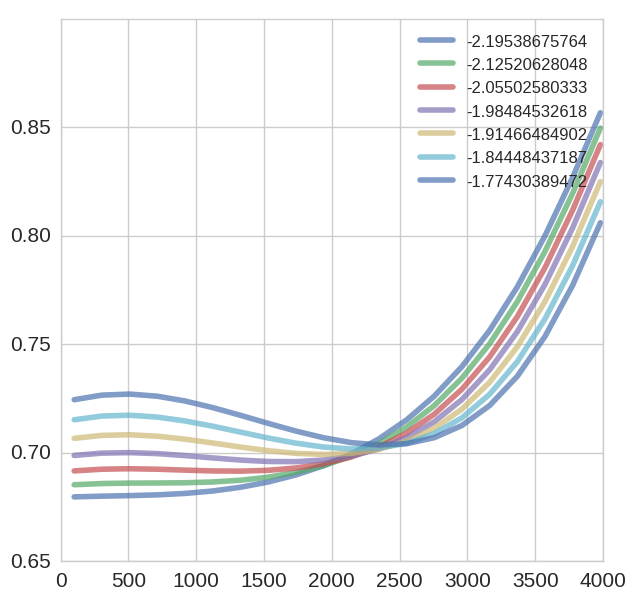

In [74]:
xminfoo,xmaxfoo,yminfoo,ymaxfoo=100,3980,1750,1950
medmodelfocus=-np.median(allparams[:,3])
stdmodelfocus=np.std(allparams[:,3])
plusfocus=medmodelfocus
nfocusstd=.5
nxbins=20

ypos=1850.
xposs=np.linspace(xminfoo,xmaxfoo,nxbins)

plt.figure(figsize=(7,7))

for plusfocus in np.linspace(medmodelfocus-nfocusstd*stdmodelfocus,medmodelfocus+nfocusstd*stdmodelfocus,7):
    modelx2,modely2=[],[]
    for xpos in xposs:
        focusparams=np.array([polyval2d(ypos,xpos,allmodels[i]) for i in range(11)])
        #focusparams[1]=0
        #focusparams[2]=0
        #ocusparams[0]+=1
        focusparams[3]+=plusfocus
        #print(xpos,focusparams[3])
        modelstamp=makeStar(*focusparams)
        outD=ME(modelstamp)
        rm,xm,ym,xym=calc_secmoms_gwin(modelstamp,(8,8),8,0.0,1)
        modelx2.append(xm)#np.sqrt(outD['x2']))#
        modely2.append(ym)#np.sqrt(outD['y2']))#
    
    modelx2=np.array(modelx2)
    modely2=np.array(modely2)
    
    plt.plot(xposs,modelx2,lw=4,alpha=.7,label=str(plusfocus))
plt.legend(fontsize=12)

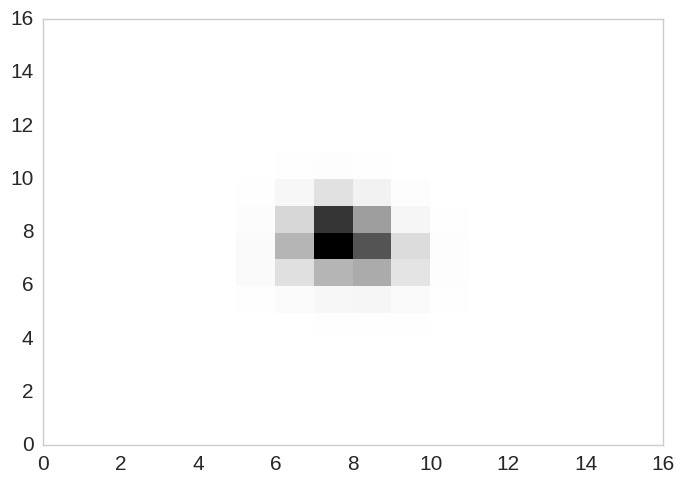

In [72]:
plt.pcolor(modelstamp)

[0, 4000, 0.4, 1.8]

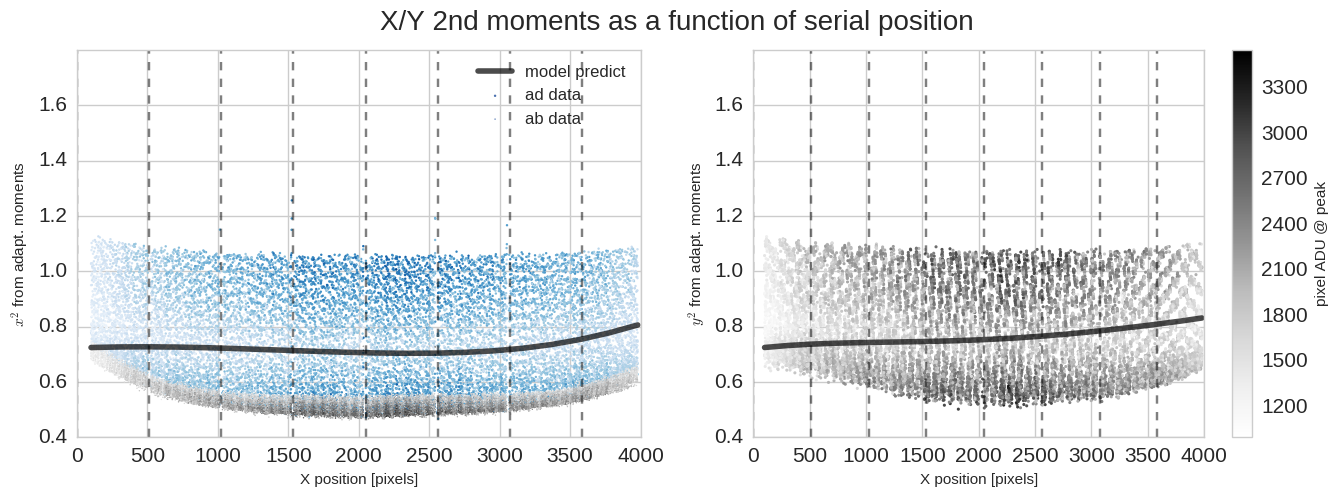

In [69]:
plt.figure(figsize=(16,5))
plotaxis=[0,4000,.4,1.8]

plt.subplot(121)
plt.scatter(datxc,datx2, c=datfmax,s=3,lw=0,label='ad data',cmap=plt.cm.Blues)#,vmin=z.min(),vmax=z.max(),s=50)
plt.scatter(xc_all,xm_all, c=datfmax,s=1,lw=0,label='ab data',cmap=plt.cm.Greys)
#plt.colorbar(label='pixel ADU @ peak')
plt.plot(xposs,modelx2,'k',lw=4,alpha=.7,label='model predict')
for i in range(8):
    plt.axvline(i*512,linestyle='--',color='k',alpha=.5)
#plt.ylim(.20,.35)
plt.xlabel('X position [pixels]')
plt.ylabel('$x^2$ from adapt. moments')
plt.axis(plotaxis)

plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(datxc,daty2, c=datfmax,s=5,lw=0)
plt.colorbar(label='pixel ADU @ peak')
plt.plot(xposs,modely2,'k',lw=4,alpha=.7,label='model predict')
for i in range(8):
    plt.axvline(i*512,linestyle='--',color='k',alpha=.5)
#plt.ylim(.15,.35)
plt.xlabel('X position [pixels]')
plt.ylabel('$y^2$ from adapt. moments')
plt.suptitle('X/Y 2nd moments as a function of serial position')
plt.axis(plotaxis)



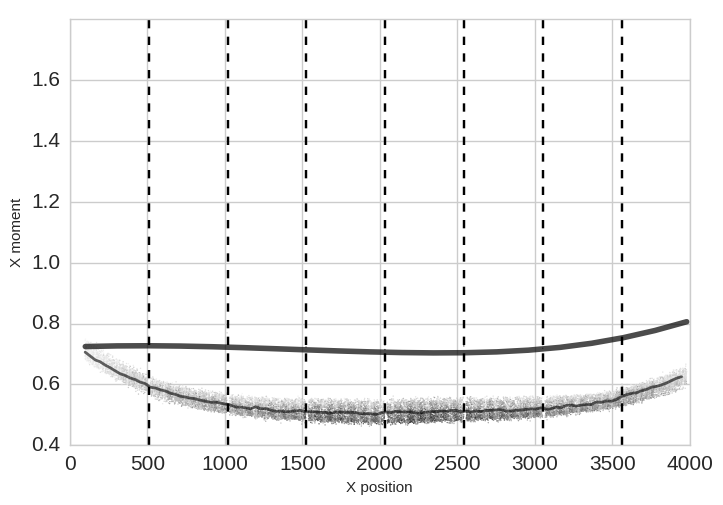

In [73]:
plotcolor='g'
#plt.plot(xc_all,xm_all,'.',color=plotcolor,alpha=.02)
plt.scatter(xc_all,xm_all, c=datfmax,s=1,lw=0,label='data')
plt.plot(xposs,modelx2,'k',lw=4,alpha=.7,label='model predict')
xfoom,yfoom,nfoom=median_xy(xc_all,xm_all,120)
plt.plot(xfoom,yfoom,color='k',linewidth=2,alpha=.6)
plt.xlabel('X position')
plt.ylabel('X moment')
plt.ylim(.4,.8)
plt.axis(plotaxis)
for i in range(1,8): plt.axvline(509*i,color='k',linestyle='--')

In [ ]:
plt.figure(figsize=(16,5))
plotaxis=[0,4000,0,1.4]

plt.subplot(121)
plt.scatter(datxc,datx2, c=datfmax,s=5,lw=0,label='data')#,vmin=z.min(),vmax=z.max(),s=50)
#plt.colorbar(label='pixel ADU @ peak')
plt.plot(xposs,modelx2,'k',lw=4,alpha=.7,label='model predict')
for i in range(8):
    plt.axvline(i*512,linestyle='--',color='k',alpha=.5)
#plt.ylim(.20,.35)
plt.xlabel('X position [pixels]')
plt.ylabel('$x^2$ from adapt. moments')
plt.axis(plotaxis)
plt.legend()

plt.subplot(122)
plt.scatter(datxc,daty2, c=datfmax,s=5,lw=0)
plt.colorbar(label='pixel ADU @ peak')
plt.plot(xposs,modely2,'k',lw=4,alpha=.7,label='model predict')
for i in range(8):
    plt.axvline(i*512,linestyle='--',color='k',alpha=.5)
#plt.ylim(.15,.35)
plt.xlabel('X position [pixels]')
plt.ylabel('$y^2$ from adapt. moments')
plt.suptitle('X/Y 2nd moments as a function of serial position')
plt.axis(plotaxis)

# Testing parallel python 

In [945]:
# run ipcluster start -n 8 on comp first (after pip install ipyparallel)

import ipyparallel as parallel
from datetime import datetime

cluster = parallel.Client()

balanced       = cluster.load_balanced_view()
direct         = cluster[:]
balanced.block = True
direct.block   = True

print(cluster.profile,cluster.ids)

default [0, 1, 2, 3, 4, 5, 6, 7]


In [947]:
# The %px magic executes a single Python command on
# the engines specified by the targets attribute of
# the DirectView instance.
#
# http://ipython.org/ipython-doc/stable/parallel/magics.html#px
%px import socket
%px print("hosts:", socket.gethostname())
 
# calculate square numbers in parallel. Print result.
squares = cluster[:].map_sync(lambda x: x**1, range(32))
print("squares:", squares)

[stdout:0] ('hosts:', 'andrew-laptop')
[stdout:1] ('hosts:', 'andrew-laptop')
[stdout:2] ('hosts:', 'andrew-laptop')
[stdout:3] ('hosts:', 'andrew-laptop')
[stdout:4] ('hosts:', 'andrew-laptop')
[stdout:5] ('hosts:', 'andrew-laptop')
[stdout:6] ('hosts:', 'andrew-laptop')
[stdout:7] ('hosts:', 'andrew-laptop')
squares: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [37]:
from IPython.parallel import *

def getpid():
    import os
    return os.getpid()

def checkhostname():
    import socket
    return socket.gethostname()

client = Client()
direct         = client[:]


balanced       = client.load_balanced_view()


balanced.block = True
direct.block   = True




export_dict = {k: globals()[k] for k in ('getpid', 'checkhostname')}
direct.push(export_dict, block=True)




from datetime import datetime

with direct.sync_imports():
    from datetime import datetime
    

def hello_engine():
    time_str = datetime.ctime(datetime.now())
    return "Hello from running engine with PID [%d] on host [%s] at [%s]" % (
                getpid(),
                checkhostname(),
                time_str)




hellos_first_try = direct.apply(hello_engine)
print(hellos_first_try)

@direct.parallel(block=True)
def calc_avg(ith):
    """ sss
    """
    return (period[0], data[field].mean())

#continue here https://www.wakari.io/sharing/bundle/ijstokes/ipcluster-wakari-intro

#%time results = calc_avg.map(data_by_month, month_index)
#results

/home/andrew/.local/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


KeyboardInterrupt: 

In [ ]:

run pidigits.py

In [5]: filestring = 'pi200m.ascii.%(i)02dof20'

# Create the list of files to process.
In [6]: files = [filestring % {'i':i} for i in range(1,16)]

In [7]: files
Out[7]:
['pi200m.ascii.01of20',
 'pi200m.ascii.02of20',
 'pi200m.ascii.03of20',
 'pi200m.ascii.04of20',
 'pi200m.ascii.05of20',
 'pi200m.ascii.06of20',
 'pi200m.ascii.07of20',
 'pi200m.ascii.08of20',
 'pi200m.ascii.09of20',
 'pi200m.ascii.10of20',
 'pi200m.ascii.11of20',
 'pi200m.ascii.12of20',
 'pi200m.ascii.13of20',
 'pi200m.ascii.14of20',
 'pi200m.ascii.15of20']

# This is the parallel calculation using the Client.map method
# which applies compute_two_digit_freqs to each file in files in parallel.
freqs_all = v.map(compute_two_digit_freqs, files)

# Add up the frequencies from each engine.
In [10]: freqs = reduce_freqs(freqs_all)

In [11]: plot_two_digit_freqs(freqs)
Out[11]: <matplotlib.image.AxesImage object at 0x18beb110>

In [12]: plt.title('2 digit counts of 150m digits of pi')
Out[12]: <matplotlib.text.Text object at 0x18d1f9b0>


In [62]:
@direct.parallel(block=True)
def add_one(thingtoadd):
    return thingtoadd+1

NameError: name 'direct' is not defined

In [954]:
add_one.map(list(np.arange(14)))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [84]:
import h5py

In [118]:
thedata=np.vstack(((thecatnames,allinds,allparams[:,0],allparams[:,1],allparams[:,2],allparams[:,3],
                   allparams[:,4],allparams[:,5],allparams[:,6],allparams[:,7]),allparams[:,8],
                   allparams[:,9],allparams[:,10]))[0]

In [130]:
datah5=h5py.File('randominds.h5','w')
datah5.create_dataset('first',data=thedata)
datah5.close()